In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-08-10 23:59:09.399474


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-9.7880)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(6.1169)
penalty_target_min tensor(-11.5544) penalty_target_max tensor(5.6463)
train_loss:  -8.043964761543275
valid_loss:  -8.192152389526367
h_min_tilde -11.554436 ell_tilde -8.073602287139895 kappa_tilde 0.0002679960437651657


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 3.5762786865234375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 5.122903108596802

 2 4.859104156494141

 3 4.636510848999023

 4 4.481933832168579

 5 4.515835523605347

 6 5.670294523239136

 7 9.042569160461426

 8 8.266693115234375

 9 4.411294221878052

 10 4.584496974945068

 11 4.743471384048462

 12 6.575265407562256

 13 4.936871290206909

 14 8.013715744018555

 15 7.124146223068237

 16 4.54792857170105

 17 4.36786150932312

 18 6.514187812805176

 19 5.306790113449097

 20 4.624979257583618

 21 4.996801853179932

 22 4.764853477478027

 23 6.453436851501465

 24 5.300213575363159

 25 4.703814506530762

 26 4.40461802482605

 27 4.39936375617981

 28 4.702572822570801

 29 4.400099754333496

 30 4.399711608886719

 31 7.723807096481323

 32 8.312441110610962

 33 4.510519742965698

 34 6.365950345993042

 35 8.743860483169556

 36 8.635679006576538

 37 8.938772201538086

 38 4.9602580070495605

 39 4.483804941177368

 40 4.390882968902588

 41 4.395737171173096

 42 4.564395189285278

 43 6.530760765075684

 44 5.191540718078613


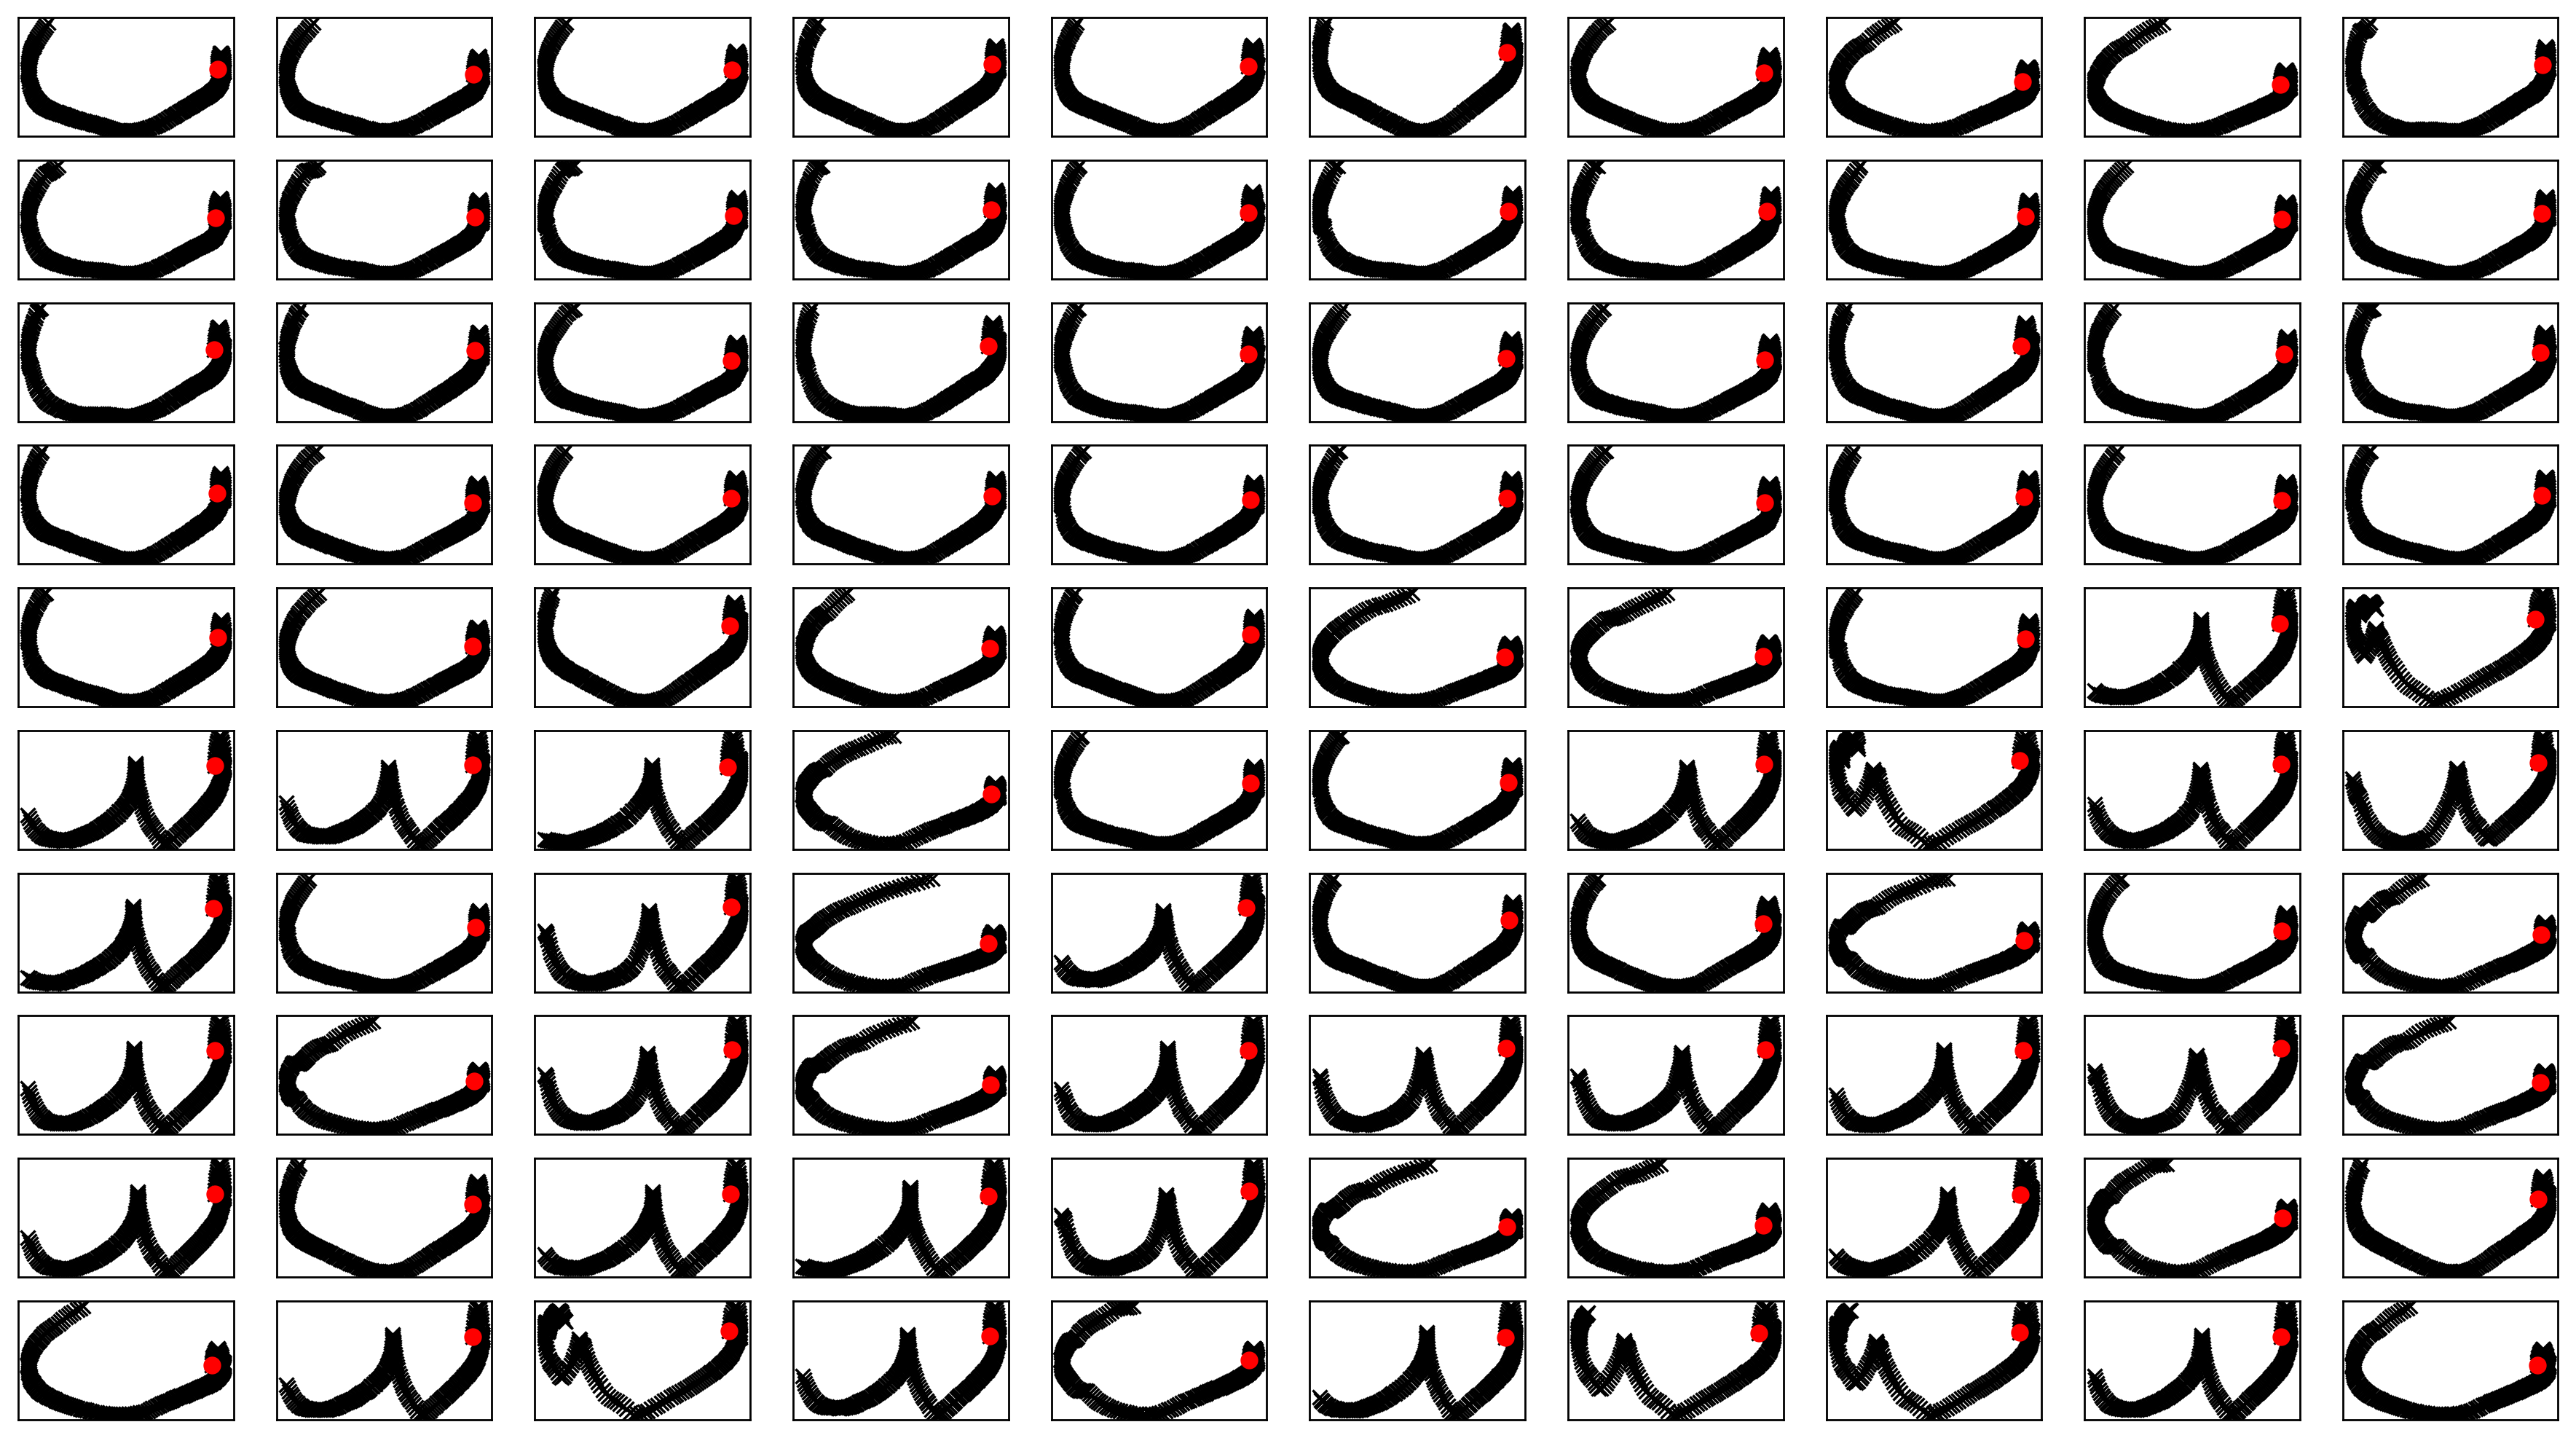

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

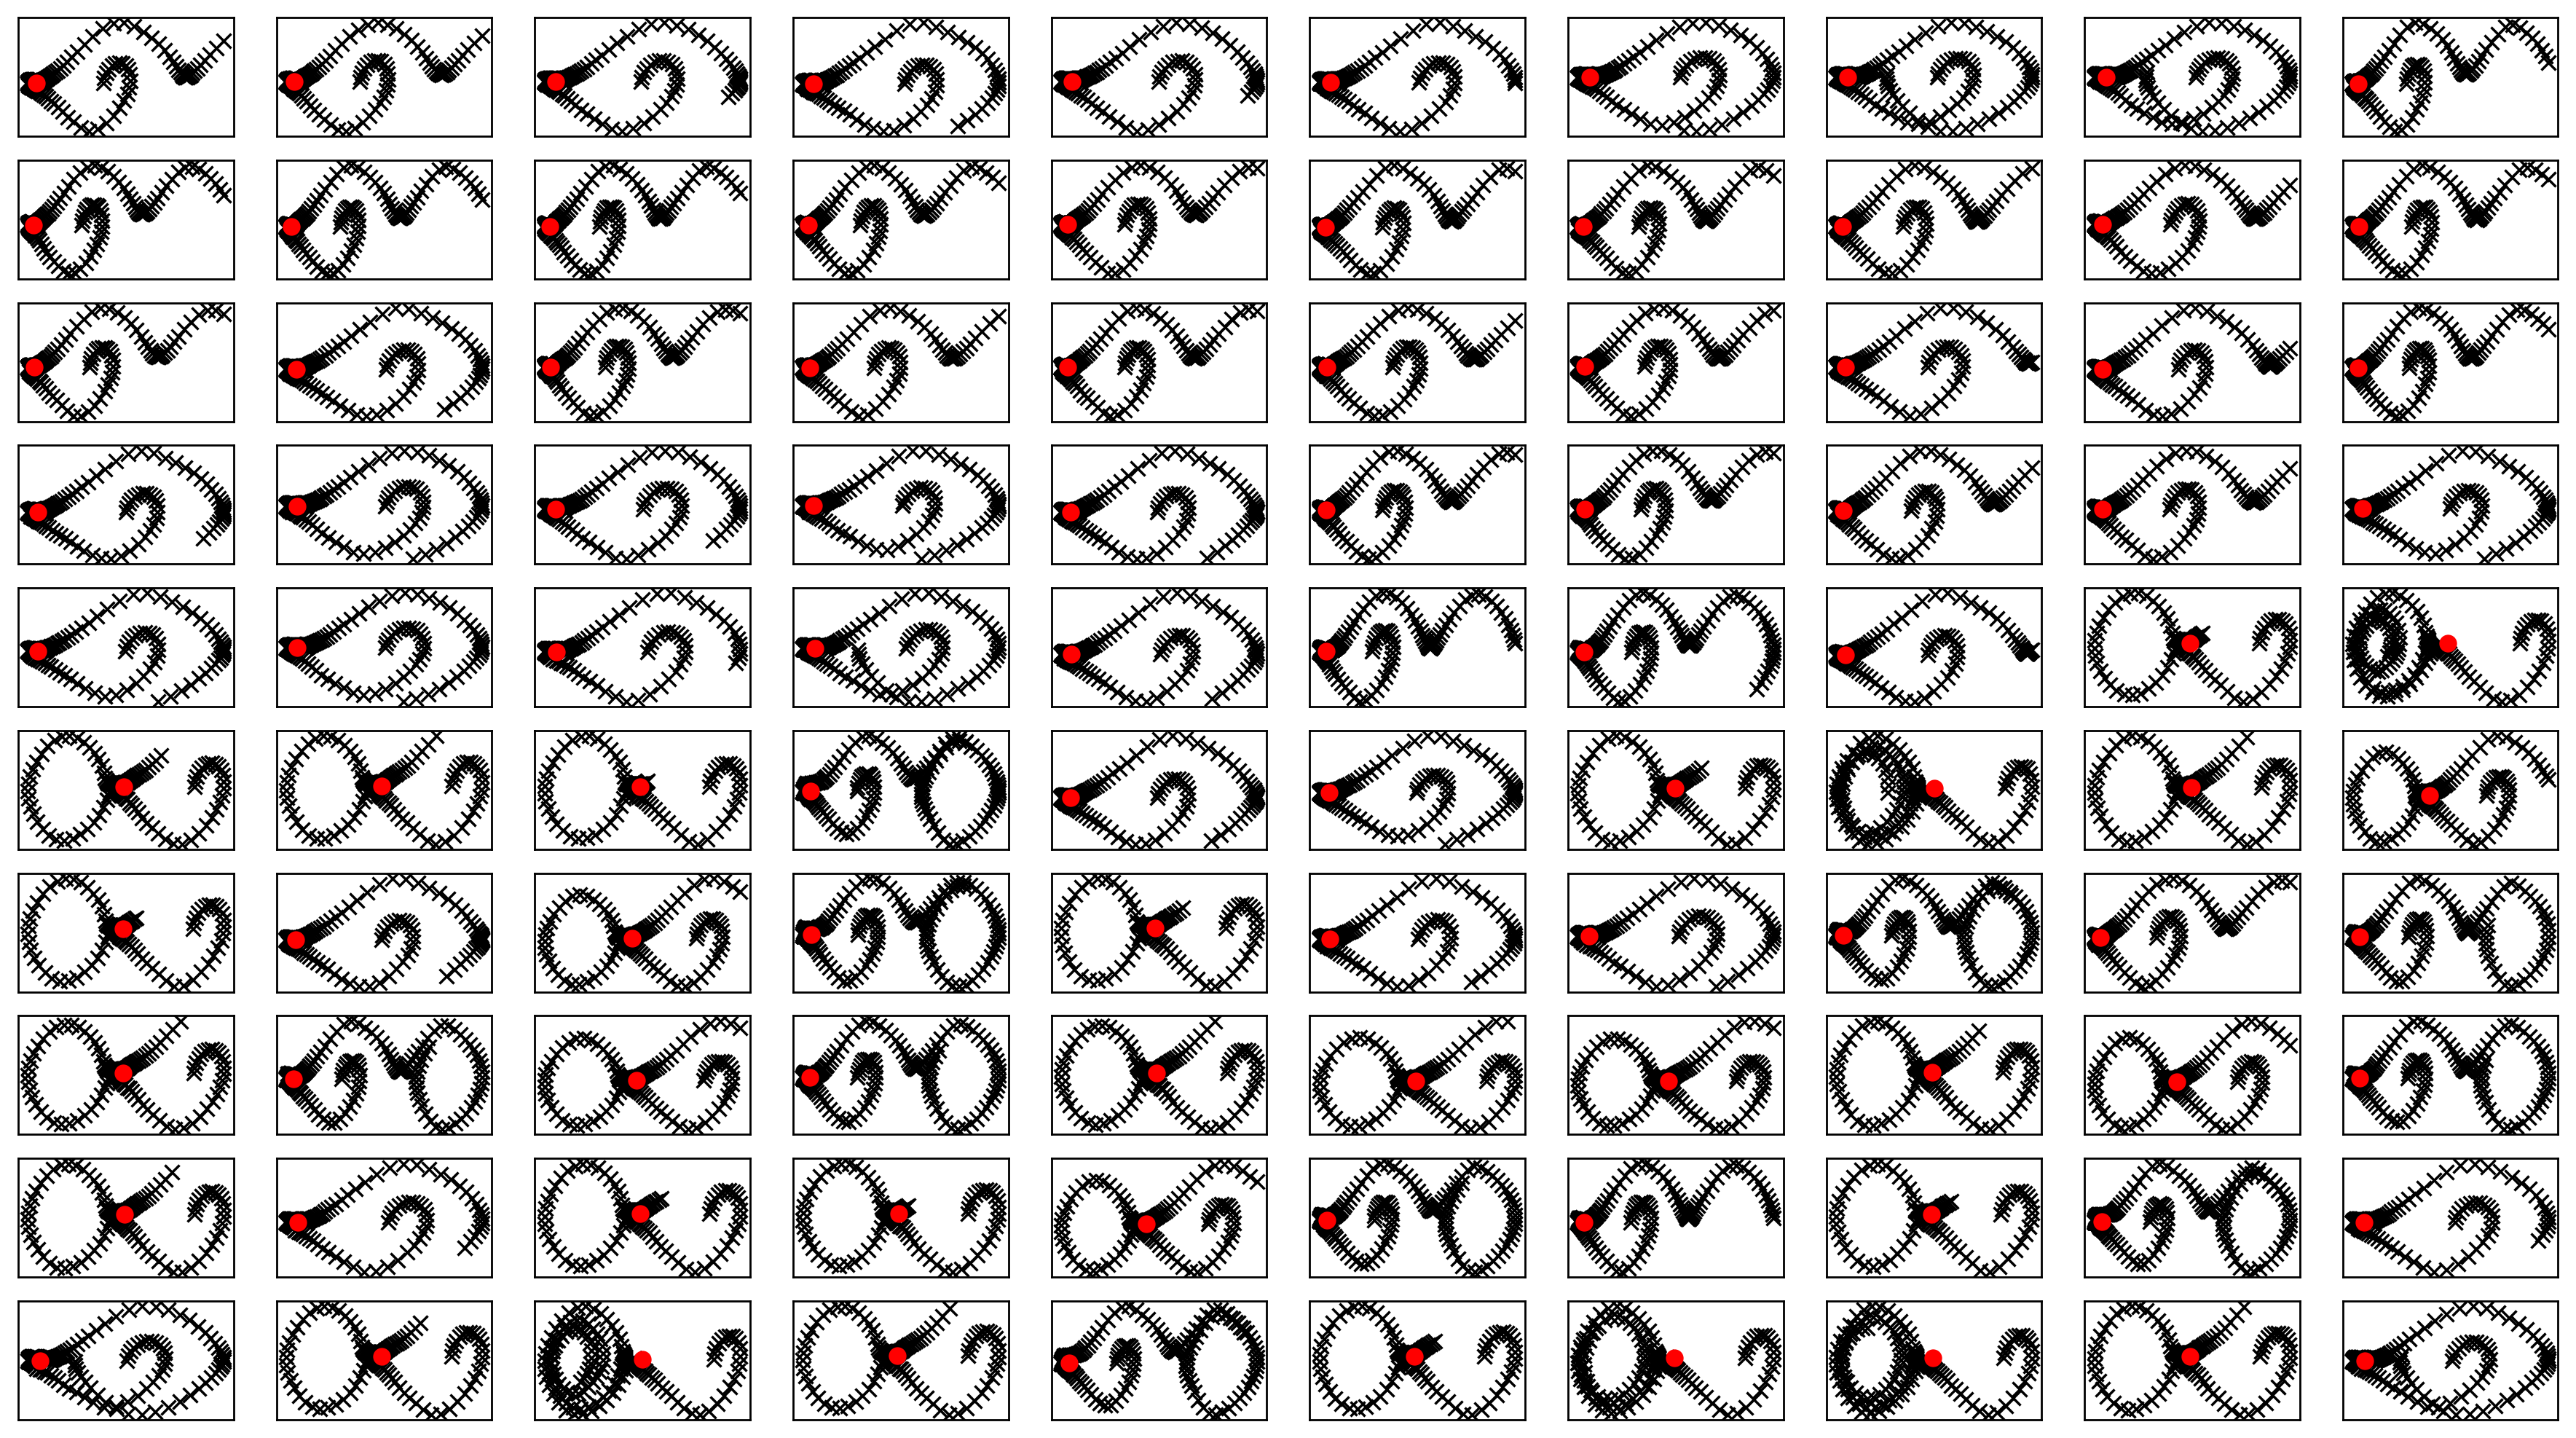

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-08-11 00:08:47.494692


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.34342  validloss 1.43043±0.00000  bestvalidloss 1.43043  last_update 0
train: iter 1  trainloss 1.18389  validloss 1.26407±0.00000  bestvalidloss 1.26407  last_update 0
train: iter 2  trainloss 1.06934  validloss 1.07891±0.00000  bestvalidloss 1.07891  last_update 0
train: iter 3  trainloss 0.99794  validloss 0.96870±0.00000  bestvalidloss 0.96870  last_update 0
train: iter 4  trainloss 0.93292  validloss 0.89833±0.00000  bestvalidloss 0.89833  last_update 0
train: iter 5  trainloss 0.89652  validloss 0.84532±0.00000  bestvalidloss 0.84532  last_update 0
train: iter 6  trainloss 0.85330  validloss 0.80385±0.00000  bestvalidloss 0.80385  last_update 0
train: iter 7  trainloss 0.82269  validloss 0.75137±0.00000  bestvalidloss 0.75137  last_update 0
train: iter 8  trainloss 0.78335  validloss 0.71241±0.00000  bestvalidloss 0.71241  last_update 0
train: iter 9  trainloss 0.76120  validloss 0.67068±0.00000  bestvalidloss 0.67068  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.36700  validloss 0.32886±0.00000  bestvalidloss 0.32886  last_update 0
train: iter 84  trainloss 0.36333  validloss 0.35168±0.00000  bestvalidloss 0.32886  last_update 1
train: iter 85  trainloss 0.36670  validloss 0.34196±0.00000  bestvalidloss 0.32886  last_update 2
train: iter 86  trainloss 0.36304  validloss 0.34638±0.00000  bestvalidloss 0.32886  last_update 3
train: iter 87  trainloss 0.36036  validloss 0.33210±0.00000  bestvalidloss 0.32886  last_update 4
train: iter 88  trainloss 0.36058  validloss 0.33591±0.00000  bestvalidloss 0.32886  last_update 5
train: iter 89  trainloss 0.35423  validloss 0.32649±0.00000  bestvalidloss 0.32649  last_update 0
train: iter 90  trainloss 0.36279  validloss 0.34350±0.00000  bestvalidloss 0.32649  last_update 1
train: iter 91  trainloss 0.35435  validloss 0.32837±0.00000  bestvalidloss 0.32649  last_update 2
train: iter 92  trainloss 0.35739  validloss 0.33213±0.00000  bestvalidloss 0.32649  last_update 3
train: ite

train: iter 166  trainloss 0.31295  validloss 0.29955±0.00000  bestvalidloss 0.28827  last_update 1
train: iter 167  trainloss 0.30882  validloss 0.29149±0.00000  bestvalidloss 0.28827  last_update 2
train: iter 168  trainloss 0.31006  validloss 0.28978±0.00000  bestvalidloss 0.28827  last_update 3
train: iter 169  trainloss 0.31070  validloss 0.28840±0.00000  bestvalidloss 0.28827  last_update 4
train: iter 170  trainloss 0.30988  validloss 0.29042±0.00000  bestvalidloss 0.28827  last_update 5
train: iter 171  trainloss 0.30781  validloss 0.29342±0.00000  bestvalidloss 0.28827  last_update 6
train: iter 172  trainloss 0.31046  validloss 0.29833±0.00000  bestvalidloss 0.28827  last_update 7
train: iter 173  trainloss 0.31407  validloss 0.29783±0.00000  bestvalidloss 0.28827  last_update 8
train: iter 174  trainloss 0.30638  validloss 0.29471±0.00000  bestvalidloss 0.28827  last_update 9
train: iter 175  trainloss 0.30744  validloss 0.30042±0.00000  bestvalidloss 0.28827  last_update 10

train: iter 248  trainloss 0.27609  validloss 0.26818±0.00000  bestvalidloss 0.26558  last_update 1
train: iter 249  trainloss 0.27950  validloss 0.27751±0.00000  bestvalidloss 0.26558  last_update 2
train: iter 250  trainloss 0.27564  validloss 0.27569±0.00000  bestvalidloss 0.26558  last_update 3
train: iter 251  trainloss 0.27628  validloss 0.28131±0.00000  bestvalidloss 0.26558  last_update 4
train: iter 252  trainloss 0.27969  validloss 0.27284±0.00000  bestvalidloss 0.26558  last_update 5
train: iter 253  trainloss 0.27276  validloss 0.29424±0.00000  bestvalidloss 0.26558  last_update 6
train: iter 254  trainloss 0.28592  validloss 0.33683±0.00000  bestvalidloss 0.26558  last_update 7
train: iter 255  trainloss 0.27738  validloss 0.28307±0.00000  bestvalidloss 0.26558  last_update 8
train: iter 256  trainloss 0.27758  validloss 0.26663±0.00000  bestvalidloss 0.26558  last_update 9
train: iter 257  trainloss 0.28269  validloss 0.26148±0.00000  bestvalidloss 0.26148  last_update 0


train: iter 330  trainloss 0.25732  validloss 0.25192±0.00000  bestvalidloss 0.24963  last_update 4
train: iter 331  trainloss 0.25805  validloss 0.26356±0.00000  bestvalidloss 0.24963  last_update 5
train: iter 332  trainloss 0.25527  validloss 0.25737±0.00000  bestvalidloss 0.24963  last_update 6
train: iter 333  trainloss 0.26176  validloss 0.26746±0.00000  bestvalidloss 0.24963  last_update 7
train: iter 334  trainloss 0.26475  validloss 0.25983±0.00000  bestvalidloss 0.24963  last_update 8
train: iter 335  trainloss 0.25480  validloss 0.25462±0.00000  bestvalidloss 0.24963  last_update 9
train: iter 336  trainloss 0.26073  validloss 0.26322±0.00000  bestvalidloss 0.24963  last_update 10
train: iter 337  trainloss 0.25654  validloss 0.25172±0.00000  bestvalidloss 0.24963  last_update 11
train: iter 338  trainloss 0.25878  validloss 0.25499±0.00000  bestvalidloss 0.24963  last_update 12
train: iter 339  trainloss 0.25808  validloss 0.29706±0.00000  bestvalidloss 0.24963  last_update

train: iter 412  trainloss 0.24080  validloss 0.24140±0.00000  bestvalidloss 0.24140  last_update 0
train: iter 413  trainloss 0.24289  validloss 0.24487±0.00000  bestvalidloss 0.24140  last_update 1
train: iter 414  trainloss 0.24077  validloss 0.27000±0.00000  bestvalidloss 0.24140  last_update 2
train: iter 415  trainloss 0.24295  validloss 0.24479±0.00000  bestvalidloss 0.24140  last_update 3
train: iter 416  trainloss 0.24463  validloss 0.24819±0.00000  bestvalidloss 0.24140  last_update 4
train: iter 417  trainloss 0.24201  validloss 0.27794±0.00000  bestvalidloss 0.24140  last_update 5
train: iter 418  trainloss 0.24434  validloss 0.25495±0.00000  bestvalidloss 0.24140  last_update 6
train: iter 419  trainloss 0.24370  validloss 0.25072±0.00000  bestvalidloss 0.24140  last_update 7
train: iter 420  trainloss 0.24569  validloss 0.25181±0.00000  bestvalidloss 0.24140  last_update 8
train: iter 421  trainloss 0.24159  validloss 0.24899±0.00000  bestvalidloss 0.24140  last_update 9


train: iter 494  trainloss 0.23068  validloss 0.23975±0.00000  bestvalidloss 0.23621  last_update 29
train: iter 495  trainloss 0.23112  validloss 0.23855±0.00000  bestvalidloss 0.23621  last_update 30
train: iter 496  trainloss 0.23044  validloss 0.23767±0.00000  bestvalidloss 0.23621  last_update 31
train: iter 497  trainloss 0.23043  validloss 0.23690±0.00000  bestvalidloss 0.23621  last_update 32
train: iter 498  trainloss 0.23381  validloss 0.23549±0.00000  bestvalidloss 0.23549  last_update 0
train: iter 499  trainloss 0.23072  validloss 0.24381±0.00000  bestvalidloss 0.23549  last_update 1
train: iter 500  trainloss 0.23115  validloss 0.24309±0.00000  bestvalidloss 0.23549  last_update 2
train: iter 501  trainloss 0.23102  validloss 0.23867±0.00000  bestvalidloss 0.23549  last_update 3
train: iter 502  trainloss 0.22612  validloss 0.23670±0.00000  bestvalidloss 0.23549  last_update 4
train: iter 503  trainloss 0.23260  validloss 0.23944±0.00000  bestvalidloss 0.23549  last_updat

train: iter 576  trainloss 0.22394  validloss 0.24271±0.00000  bestvalidloss 0.22916  last_update 6
train: iter 577  trainloss 0.22677  validloss 0.23848±0.00000  bestvalidloss 0.22916  last_update 7
train: iter 578  trainloss 0.22509  validloss 0.23808±0.00000  bestvalidloss 0.22916  last_update 8
train: iter 579  trainloss 0.22342  validloss 0.24105±0.00000  bestvalidloss 0.22916  last_update 9
train: iter 580  trainloss 0.22336  validloss 0.23234±0.00000  bestvalidloss 0.22916  last_update 10
train: iter 581  trainloss 0.22009  validloss 0.23663±0.00000  bestvalidloss 0.22916  last_update 11
train: iter 582  trainloss 0.22674  validloss 0.23725±0.00000  bestvalidloss 0.22916  last_update 12
train: iter 583  trainloss 0.22183  validloss 0.24189±0.00000  bestvalidloss 0.22916  last_update 13
train: iter 584  trainloss 0.22118  validloss 0.23340±0.00000  bestvalidloss 0.22916  last_update 14
train: iter 585  trainloss 0.22239  validloss 0.23620±0.00000  bestvalidloss 0.22916  last_upda

train: iter 658  trainloss 0.21954  validloss 0.24653±0.00000  bestvalidloss 0.22365  last_update 17
train: iter 659  trainloss 0.21822  validloss 0.23302±0.00000  bestvalidloss 0.22365  last_update 18
train: iter 660  trainloss 0.21391  validloss 0.22772±0.00000  bestvalidloss 0.22365  last_update 19
train: iter 661  trainloss 0.21873  validloss 0.23432±0.00000  bestvalidloss 0.22365  last_update 20
train: iter 662  trainloss 0.21550  validloss 0.23399±0.00000  bestvalidloss 0.22365  last_update 21
train: iter 663  trainloss 0.21317  validloss 0.23102±0.00000  bestvalidloss 0.22365  last_update 22
train: iter 664  trainloss 0.21403  validloss 0.23766±0.00000  bestvalidloss 0.22365  last_update 23
train: iter 665  trainloss 0.21184  validloss 0.23028±0.00000  bestvalidloss 0.22365  last_update 24
train: iter 666  trainloss 0.21303  validloss 0.23137±0.00000  bestvalidloss 0.22365  last_update 25
train: iter 667  trainloss 0.21866  validloss 0.23096±0.00000  bestvalidloss 0.22365  last_

train: iter 740  trainloss 0.21639  validloss 0.24280±0.00000  bestvalidloss 0.22192  last_update 7
train: iter 741  trainloss 0.20848  validloss 0.22421±0.00000  bestvalidloss 0.22192  last_update 8
train: iter 742  trainloss 0.21278  validloss 0.22718±0.00000  bestvalidloss 0.22192  last_update 9
train: iter 743  trainloss 0.20814  validloss 0.22553±0.00000  bestvalidloss 0.22192  last_update 10
train: iter 744  trainloss 0.20700  validloss 0.22672±0.00000  bestvalidloss 0.22192  last_update 11
train: iter 745  trainloss 0.20951  validloss 0.23194±0.00000  bestvalidloss 0.22192  last_update 12
train: iter 746  trainloss 0.20576  validloss 0.23148±0.00000  bestvalidloss 0.22192  last_update 13
train: iter 747  trainloss 0.20674  validloss 0.22502±0.00000  bestvalidloss 0.22192  last_update 14
train: iter 748  trainloss 0.20948  validloss 0.22615±0.00000  bestvalidloss 0.22192  last_update 15
train: iter 749  trainloss 0.20599  validloss 0.22927±0.00000  bestvalidloss 0.22192  last_upd

train: iter 822  trainloss 0.20219  validloss 0.22873±0.00000  bestvalidloss 0.21958  last_update 42
train: iter 823  trainloss 0.19926  validloss 0.23195±0.00000  bestvalidloss 0.21958  last_update 43
train: iter 824  trainloss 0.19963  validloss 0.23279±0.00000  bestvalidloss 0.21958  last_update 44
train: iter 825  trainloss 0.20046  validloss 0.22366±0.00000  bestvalidloss 0.21958  last_update 45
train: iter 826  trainloss 0.20067  validloss 0.22151±0.00000  bestvalidloss 0.21958  last_update 46
train: iter 827  trainloss 0.20599  validloss 0.22461±0.00000  bestvalidloss 0.21958  last_update 47
train: iter 828  trainloss 0.20106  validloss 0.22230±0.00000  bestvalidloss 0.21958  last_update 48
train: iter 829  trainloss 0.20271  validloss 0.23165±0.00000  bestvalidloss 0.21958  last_update 49
train: iter 830  trainloss 0.20137  validloss 0.22604±0.00000  bestvalidloss 0.21958  last_update 50
train: iter 831  trainloss 0.19792  validloss 0.23143±0.00000  bestvalidloss 0.21958  last_

train_loss:  -1.425832578456402
valid_loss:  -2.015931528711319
weight_alpha 1.0 h_min_tilde -11.554436 ell_tilde -1.5438523685073855 kappa_tilde 0.0001580302805433132
train_loss:  -3.5926047107696535
valid_loss:  -3.793733071899413
weight_alpha 0.1 h_min_tilde -11.554436 ell_tilde -3.6328303829956052 kappa_tilde 0.00017764926020454342


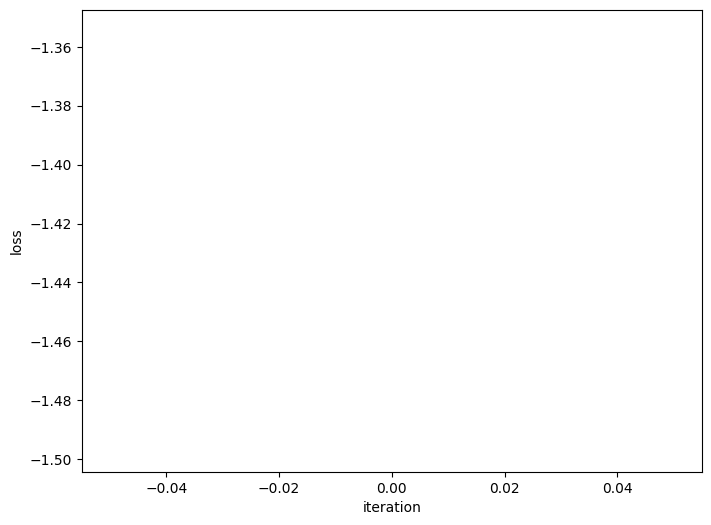

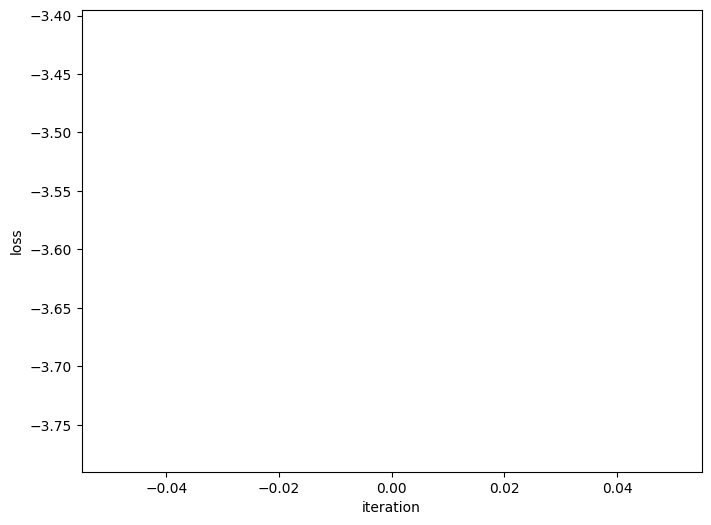

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -682.95439  validloss -758.15447±0.00000  bestvalidloss -758.15447  last_update 0
train: iter 1  trainloss -719.37643  validloss -779.55616±0.00000  bestvalidloss -779.55616  last_update 0
train: iter 2  trainloss -722.08337  validloss -774.87560±0.00000  bestvalidloss -779.55616  last_update 1
train: iter 3  trainloss -724.72423  validloss -762.82937±0.00000  bestvalidloss -779.55616  last_update 2
train: iter 4  trainloss -717.69225  validloss -771.28889±0.00000  bestvalidloss -779.55616  last_update 3
train: iter 5  trainloss -705.09822  validloss -757.08616±0.00000  bestvalidloss -779.55616  last_update 4
train: iter 6  trainloss -718.52808  validloss -730.38893±0.00000  bestvalidloss -779.55616  last_update 5
train: iter 7  trainloss -727.69959  validloss -780.40414±0.00000  bestvalidloss -780.40414  last_update 0
train: iter 8  trainloss -727.14374  validloss -785.02738±0.00000  bestvalidloss -785.02738  last_u

train: iter 76  trainloss -768.14694  validloss -797.10969±0.00000  bestvalidloss -817.99916  last_update 14
train: iter 77  trainloss -780.25358  validloss -807.61919±0.00000  bestvalidloss -817.99916  last_update 15
train: iter 78  trainloss -778.69630  validloss -803.52901±0.00000  bestvalidloss -817.99916  last_update 16
train: iter 79  trainloss -790.70555  validloss -815.27597±0.00000  bestvalidloss -817.99916  last_update 17
train: iter 80  trainloss -759.97039  validloss -808.16971±0.00000  bestvalidloss -817.99916  last_update 18
train: iter 81  trainloss -792.96510  validloss -786.84846±0.00000  bestvalidloss -817.99916  last_update 19
train: iter 82  trainloss -788.42464  validloss -786.11441±0.00000  bestvalidloss -817.99916  last_update 20
train: iter 83  trainloss -791.94443  validloss -788.27300±0.00000  bestvalidloss -817.99916  last_update 21
train: iter 84  trainloss -771.55531  validloss -742.22073±0.00000  bestvalidloss -817.99916  last_update 22
train: iter 85  tra

train: iter 152  trainloss -842.29582  validloss -841.82897±0.00000  bestvalidloss -852.77313  last_update 8
train: iter 153  trainloss -845.11748  validloss -837.69265±0.00000  bestvalidloss -852.77313  last_update 9
train: iter 154  trainloss -845.13248  validloss -846.65996±0.00000  bestvalidloss -852.77313  last_update 10
train: iter 155  trainloss -821.72350  validloss -812.84025±0.00000  bestvalidloss -852.77313  last_update 11
train: iter 156  trainloss -835.27883  validloss -819.38280±0.00000  bestvalidloss -852.77313  last_update 12
train: iter 157  trainloss -838.55518  validloss -840.69095±0.00000  bestvalidloss -852.77313  last_update 13
train: iter 158  trainloss -831.45531  validloss -803.88882±0.00000  bestvalidloss -852.77313  last_update 14
train: iter 159  trainloss -822.75715  validloss -849.96310±0.00000  bestvalidloss -852.77313  last_update 15
train: iter 160  trainloss -847.70970  validloss -827.05607±0.00000  bestvalidloss -852.77313  last_update 16
train: iter 

train: iter 227  trainloss -864.15686  validloss -861.38902±0.00000  bestvalidloss -897.28740  last_update 1
train: iter 228  trainloss -873.85459  validloss -827.73425±0.00000  bestvalidloss -897.28740  last_update 2
train: iter 229  trainloss -866.57804  validloss -699.95051±0.00000  bestvalidloss -897.28740  last_update 3
train: iter 230  trainloss -887.05675  validloss -866.09454±0.00000  bestvalidloss -897.28740  last_update 4
train: iter 231  trainloss -894.94383  validloss -864.72617±0.00000  bestvalidloss -897.28740  last_update 5
train: iter 232  trainloss -859.09799  validloss -882.55025±0.00000  bestvalidloss -897.28740  last_update 6
train: iter 233  trainloss -707.48394  validloss -787.59107±0.00000  bestvalidloss -897.28740  last_update 7
train: iter 234  trainloss -852.00411  validloss -766.17239±0.00000  bestvalidloss -897.28740  last_update 8
train: iter 235  trainloss -877.89905  validloss -845.82216±0.00000  bestvalidloss -897.28740  last_update 9
train: iter 236  tr

train: iter 302  trainloss -929.85438  validloss -900.58522±0.00000  bestvalidloss -929.05551  last_update 9
train: iter 303  trainloss -892.14570  validloss -910.62703±0.00000  bestvalidloss -929.05551  last_update 10
train: iter 304  trainloss -898.13417  validloss -853.84489±0.00000  bestvalidloss -929.05551  last_update 11
train: iter 305  trainloss -918.67905  validloss -894.73908±0.00000  bestvalidloss -929.05551  last_update 12
train: iter 306  trainloss -891.02159  validloss -814.20797±0.00000  bestvalidloss -929.05551  last_update 13
train: iter 307  trainloss -926.21919  validloss -885.54691±0.00000  bestvalidloss -929.05551  last_update 14
train: iter 308  trainloss -932.43766  validloss -891.78511±0.00000  bestvalidloss -929.05551  last_update 15
train: iter 309  trainloss -940.58420  validloss -901.66443±0.00000  bestvalidloss -929.05551  last_update 16
train: iter 310  trainloss -930.11433  validloss -916.39106±0.00000  bestvalidloss -929.05551  last_update 17
train: iter

train: iter 377  trainloss -832.19726  validloss -910.25965±0.00000  bestvalidloss -930.83443  last_update 10
train: iter 378  trainloss -933.33960  validloss -882.21788±0.00000  bestvalidloss -930.83443  last_update 11
train: iter 379  trainloss -921.07609  validloss -929.24499±0.00000  bestvalidloss -930.83443  last_update 12
train: iter 380  trainloss -945.64453  validloss -879.11148±0.00000  bestvalidloss -930.83443  last_update 13
train: iter 381  trainloss -950.31722  validloss -920.55465±0.00000  bestvalidloss -930.83443  last_update 14
train: iter 382  trainloss -965.03803  validloss -923.40229±0.00000  bestvalidloss -930.83443  last_update 15
train: iter 383  trainloss -968.25236  validloss -945.46446±0.00000  bestvalidloss -945.46446  last_update 0
train: iter 384  trainloss -962.62827  validloss -916.92552±0.00000  bestvalidloss -945.46446  last_update 1
train: iter 385  trainloss -952.43209  validloss -924.84445±0.00000  bestvalidloss -945.46446  last_update 2
train: iter 3

train: iter 452  trainloss -990.53406  validloss -954.44794±0.00000  bestvalidloss -979.35092  last_update 2
train: iter 453  trainloss -974.42358  validloss -924.27454±0.00000  bestvalidloss -979.35092  last_update 3
train: iter 454  trainloss -990.02883  validloss -916.59103±0.00000  bestvalidloss -979.35092  last_update 4
train: iter 455  trainloss -938.32603  validloss -944.13193±0.00000  bestvalidloss -979.35092  last_update 5
train: iter 456  trainloss -956.13093  validloss -859.43715±0.00000  bestvalidloss -979.35092  last_update 6
train: iter 457  trainloss -950.49756  validloss -925.67188±0.00000  bestvalidloss -979.35092  last_update 7
train: iter 458  trainloss -984.19591  validloss -922.88417±0.00000  bestvalidloss -979.35092  last_update 8
train: iter 459  trainloss -994.46496  validloss -958.39709±0.00000  bestvalidloss -979.35092  last_update 9
train: iter 460  trainloss -956.27223  validloss -816.29348±0.00000  bestvalidloss -979.35092  last_update 10
train: iter 461  t

train: iter 527  trainloss -1005.36389  validloss -979.06817±0.00000  bestvalidloss -1002.27895  last_update 20
train: iter 528  trainloss -976.51924  validloss -942.09319±0.00000  bestvalidloss -1002.27895  last_update 21
train: iter 529  trainloss -997.55703  validloss -956.80627±0.00000  bestvalidloss -1002.27895  last_update 22
train: iter 530  trainloss -1004.16277  validloss -952.41163±0.00000  bestvalidloss -1002.27895  last_update 23
train: iter 531  trainloss -988.00664  validloss -944.54478±0.00000  bestvalidloss -1002.27895  last_update 24
train: iter 532  trainloss -905.82914  validloss -929.78576±0.00000  bestvalidloss -1002.27895  last_update 25
train: iter 533  trainloss -913.77291  validloss -767.95484±0.00000  bestvalidloss -1002.27895  last_update 26
train: iter 534  trainloss -983.46941  validloss -920.74615±0.00000  bestvalidloss -1002.27895  last_update 27
train: iter 535  trainloss -1007.05975  validloss -943.60428±0.00000  bestvalidloss -1002.27895  last_update 2

train: iter 601  trainloss -1033.36111  validloss -986.38497±0.00000  bestvalidloss -1010.54277  last_update 2
train: iter 602  trainloss -982.62903  validloss -859.69353±0.00000  bestvalidloss -1010.54277  last_update 3
train: iter 603  trainloss -1031.75681  validloss -969.57706±0.00000  bestvalidloss -1010.54277  last_update 4
train: iter 604  trainloss -1036.46945  validloss -970.26568±0.00000  bestvalidloss -1010.54277  last_update 5
train: iter 605  trainloss -1040.87794  validloss -994.30601±0.00000  bestvalidloss -1010.54277  last_update 6
train: iter 606  trainloss -1023.66838  validloss -1004.74189±0.00000  bestvalidloss -1010.54277  last_update 7
train: iter 607  trainloss -1038.14492  validloss -1018.90598±0.00000  bestvalidloss -1018.90598  last_update 0
train: iter 608  trainloss -1046.82218  validloss -1017.71906±0.00000  bestvalidloss -1018.90598  last_update 1
train: iter 609  trainloss -1049.92948  validloss -955.97129±0.00000  bestvalidloss -1018.90598  last_update 2

train: iter 675  trainloss -1021.32618  validloss -997.92938±0.00000  bestvalidloss -1037.68021  last_update 4
train: iter 676  trainloss -1050.58190  validloss -970.97241±0.00000  bestvalidloss -1037.68021  last_update 5
train: iter 677  trainloss -1047.47529  validloss -1009.73236±0.00000  bestvalidloss -1037.68021  last_update 6
train: iter 678  trainloss -1059.34891  validloss -1015.70465±0.00000  bestvalidloss -1037.68021  last_update 7
train: iter 679  trainloss -1060.28085  validloss -1006.67414±0.00000  bestvalidloss -1037.68021  last_update 8
train: iter 680  trainloss -1063.85643  validloss -998.08824±0.00000  bestvalidloss -1037.68021  last_update 9
train: iter 681  trainloss -1048.35867  validloss -1022.21383±0.00000  bestvalidloss -1037.68021  last_update 10
train: iter 682  trainloss -1062.64414  validloss -1000.02870±0.00000  bestvalidloss -1037.68021  last_update 11
train: iter 683  trainloss -1053.66666  validloss -996.67286±0.00000  bestvalidloss -1037.68021  last_upd

train: iter 748  trainloss -1080.88665  validloss -1058.21159±0.00000  bestvalidloss -1059.64538  last_update 50
train: iter 749  trainloss -1072.29456  validloss -1031.91828±0.00000  bestvalidloss -1059.64538  last_update 51
train: iter 750  trainloss -1076.20465  validloss -1043.13670±0.00000  bestvalidloss -1059.64538  last_update 52
train: iter 751  trainloss -1060.53635  validloss -1028.65097±0.00000  bestvalidloss -1059.64538  last_update 53
train: iter 752  trainloss -1069.99992  validloss -1058.11685±0.00000  bestvalidloss -1059.64538  last_update 54
train: iter 753  trainloss -1056.57152  validloss -1040.87764±0.00000  bestvalidloss -1059.64538  last_update 55
train: iter 754  trainloss -1055.55789  validloss -1036.45797±0.00000  bestvalidloss -1059.64538  last_update 56
train: iter 755  trainloss -1078.80465  validloss -1032.97401±0.00000  bestvalidloss -1059.64538  last_update 57
train: iter 756  trainloss -1083.93549  validloss -1047.17891±0.00000  bestvalidloss -1059.64538

train: iter 821  trainloss -1111.14351  validloss -1035.87384±0.00000  bestvalidloss -1065.36836  last_update 26
train: iter 822  trainloss -1087.61257  validloss -1049.99065±0.00000  bestvalidloss -1065.36836  last_update 27
train: iter 823  trainloss -1011.16039  validloss -865.01178±0.00000  bestvalidloss -1065.36836  last_update 28
train: iter 824  trainloss -1071.52965  validloss -1034.59683±0.00000  bestvalidloss -1065.36836  last_update 29
train: iter 825  trainloss -1087.15965  validloss -1029.89682±0.00000  bestvalidloss -1065.36836  last_update 30
train: iter 826  trainloss -1102.90971  validloss -1057.33844±0.00000  bestvalidloss -1065.36836  last_update 31
train: iter 827  trainloss -1105.61451  validloss -1072.50831±0.00000  bestvalidloss -1072.50831  last_update 0
train: iter 828  trainloss -1100.68612  validloss -1045.56132±0.00000  bestvalidloss -1072.50831  last_update 1
train: iter 829  trainloss -1110.35474  validloss -1032.31131±0.00000  bestvalidloss -1072.50831  l

train: iter 894  trainloss -1107.80952  validloss -1029.31038±0.00000  bestvalidloss -1082.98887  last_update 27
train: iter 895  trainloss -1058.80638  validloss -1061.69530±0.00000  bestvalidloss -1082.98887  last_update 28
train: iter 896  trainloss -1095.33099  validloss -948.10599±0.00000  bestvalidloss -1082.98887  last_update 29
train: iter 897  trainloss -1108.38754  validloss -1053.57964±0.00000  bestvalidloss -1082.98887  last_update 30
train: iter 898  trainloss -1113.57270  validloss -1069.03476±0.00000  bestvalidloss -1082.98887  last_update 31
train: iter 899  trainloss -1110.41721  validloss -1048.43432±0.00000  bestvalidloss -1082.98887  last_update 32
train: iter 900  trainloss -1127.39443  validloss -1023.98425±0.00000  bestvalidloss -1082.98887  last_update 33
train: iter 901  trainloss -1120.56308  validloss -1044.68836±0.00000  bestvalidloss -1082.98887  last_update 34
train: iter 902  trainloss -1125.31471  validloss -1104.42567±0.00000  bestvalidloss -1104.42567 

train: iter 967  trainloss -1136.45451  validloss -1071.34315±0.00000  bestvalidloss -1104.42567  last_update 65
train: iter 968  trainloss -1103.94469  validloss -1039.91762±0.00000  bestvalidloss -1104.42567  last_update 66
train: iter 969  trainloss -1107.27112  validloss -1013.39092±0.00000  bestvalidloss -1104.42567  last_update 67
train: iter 970  trainloss -1122.80381  validloss -1014.47783±0.00000  bestvalidloss -1104.42567  last_update 68
train: iter 971  trainloss -1144.18489  validloss -1052.66244±0.00000  bestvalidloss -1104.42567  last_update 69
train: iter 972  trainloss -1142.78597  validloss -1060.32057±0.00000  bestvalidloss -1104.42567  last_update 70
train: iter 973  trainloss -1136.34633  validloss -1076.82715±0.00000  bestvalidloss -1104.42567  last_update 71
train: iter 974  trainloss -1081.36911  validloss -894.38796±0.00000  bestvalidloss -1104.42567  last_update 72
train: iter 975  trainloss -1109.77601  validloss -1058.22953±0.00000  bestvalidloss -1104.42567 

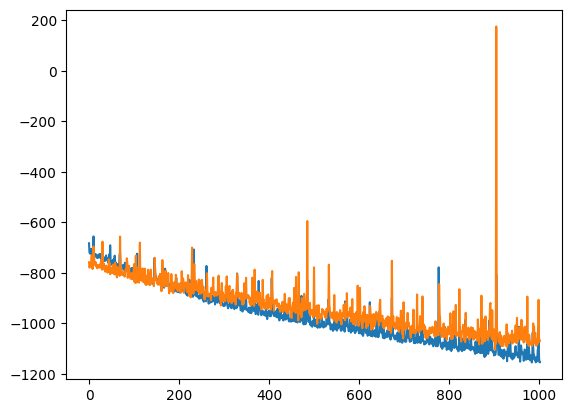

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-11 00:51:01.841844


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8
predict diverge [-93.56234859   2.01937956 -63.95559098 -34.74200484] [-1.46485977 -2.06710879 -1.64638832 -8.75210051] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 178
predict diverge [-26.84606123  24.40079669 -63.75849526 -34.62228585] [ 1.32500833  9.04126169 -1.91174588 -3.0455036 ] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 114

 9

 10

 11

 12

 13
predict diverge [ -6.35047007  22.23274515 -38.172093   -23.08927471] [ 0.60988153  1.34457564 -1.41916134  1.8607466 ] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 166

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23
predict diverge [-76.43740818 -28.10851574 -32.7964641  -24.26394283] [  0.03730967 -13.36059908  -1.20879805  -0.81544166] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511 

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.67301  validloss 2.45783±0.00000  bestvalidloss 2.45783  last_update 0
train: iter 1  trainloss 0.94731  validloss 1.02792±0.00000  bestvalidloss 1.02792  last_update 0
train: iter 2  trainloss 0.86918  validloss 0.83811±0.00000  bestvalidloss 0.83811  last_update 0
train: iter 3  trainloss 0.81539  validloss 0.80433±0.00000  bestvalidloss 0.80433  last_update 0
train: iter 4  trainloss 0.78255  validloss 0.74592±0.00000  bestvalidloss 0.74592  last_update 0
train: iter 5  trainloss 0.75723  validloss 0.76659±0.00000  bestvalidloss 0.74592  last_update 1
train: iter 6  trainloss 0.72771  validloss 0.75714±0.00000  bestvalidloss 0.74592  last_update 2
train: iter 7  trainloss 0.71070  validloss 0.73120±0.00000  bestvalidloss 0.73120  last_update 0
train: iter 8  trainloss 0.69335  validloss 0.69259±0.00000  bestvalidloss 0.69259  last_update 0
train: iter 9  trainloss 0.67250  validloss 0.71421±0.00000  bestvalidloss 0.69259  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.46499  validloss 0.64296±0.00000  bestvalidloss 0.61154  last_update 17
train: iter 84  trainloss 0.46681  validloss 0.63866±0.00000  bestvalidloss 0.61154  last_update 18
train: iter 85  trainloss 0.46681  validloss 0.66109±0.00000  bestvalidloss 0.61154  last_update 19
train: iter 86  trainloss 0.46392  validloss 0.65604±0.00000  bestvalidloss 0.61154  last_update 20
train: iter 87  trainloss 0.46312  validloss 0.64233±0.00000  bestvalidloss 0.61154  last_update 21
train: iter 88  trainloss 0.46549  validloss 0.65361±0.00000  bestvalidloss 0.61154  last_update 22
train: iter 89  trainloss 0.46314  validloss 0.66454±0.00000  bestvalidloss 0.61154  last_update 23
train: iter 90  trainloss 0.46812  validloss 0.61473±0.00000  bestvalidloss 0.61154  last_update 24
train: iter 91  trainloss 0.46280  validloss 0.62966±0.00000  bestvalidloss 0.61154  last_update 25
train: iter 92  trainloss 0.46115  validloss 0.62722±0.00000  bestvalidloss 0.61154  last_update 26


train: iter 165  trainloss 0.43037  validloss 0.61058±0.00000  bestvalidloss 0.60282  last_update 20
train: iter 166  trainloss 0.42860  validloss 0.60571±0.00000  bestvalidloss 0.60282  last_update 21
train: iter 167  trainloss 0.43092  validloss 0.62427±0.00000  bestvalidloss 0.60282  last_update 22
train: iter 168  trainloss 0.42870  validloss 0.60885±0.00000  bestvalidloss 0.60282  last_update 23
train: iter 169  trainloss 0.43486  validloss 0.62815±0.00000  bestvalidloss 0.60282  last_update 24
train: iter 170  trainloss 0.42959  validloss 0.61977±0.00000  bestvalidloss 0.60282  last_update 25
train: iter 171  trainloss 0.43077  validloss 0.62517±0.00000  bestvalidloss 0.60282  last_update 26
train: iter 172  trainloss 0.43061  validloss 0.62098±0.00000  bestvalidloss 0.60282  last_update 27
train: iter 173  trainloss 0.42970  validloss 0.60806±0.00000  bestvalidloss 0.60282  last_update 28
train: iter 174  trainloss 0.42700  validloss 0.64869±0.00000  bestvalidloss 0.60282  last_

train: iter 247  trainloss 0.41006  validloss 0.58143±0.00000  bestvalidloss 0.58143  last_update 0
train: iter 248  trainloss 0.41033  validloss 0.62638±0.00000  bestvalidloss 0.58143  last_update 1
train: iter 249  trainloss 0.41476  validloss 0.61635±0.00000  bestvalidloss 0.58143  last_update 2
train: iter 250  trainloss 0.42332  validloss 0.63280±0.00000  bestvalidloss 0.58143  last_update 3
train: iter 251  trainloss 0.40817  validloss 0.61355±0.00000  bestvalidloss 0.58143  last_update 4
train: iter 252  trainloss 0.40851  validloss 0.57872±0.00000  bestvalidloss 0.57872  last_update 0
train: iter 253  trainloss 0.40991  validloss 0.63044±0.00000  bestvalidloss 0.57872  last_update 1
train: iter 254  trainloss 0.40891  validloss 0.62248±0.00000  bestvalidloss 0.57872  last_update 2
train: iter 255  trainloss 0.40751  validloss 0.60523±0.00000  bestvalidloss 0.57872  last_update 3
train: iter 256  trainloss 0.40748  validloss 0.61529±0.00000  bestvalidloss 0.57872  last_update 4


train: iter 329  trainloss 0.39085  validloss 0.64317±0.00000  bestvalidloss 0.57872  last_update 77
train: iter 330  trainloss 0.39541  validloss 0.60540±0.00000  bestvalidloss 0.57872  last_update 78
train: iter 331  trainloss 0.39190  validloss 0.63873±0.00000  bestvalidloss 0.57872  last_update 79
train: iter 332  trainloss 0.39654  validloss 0.63058±0.00000  bestvalidloss 0.57872  last_update 80
train: iter 333  trainloss 0.39604  validloss 0.63522±0.00000  bestvalidloss 0.57872  last_update 81
train: iter 334  trainloss 0.39209  validloss 0.61801±0.00000  bestvalidloss 0.57872  last_update 82
train: iter 335  trainloss 0.38867  validloss 0.61890±0.00000  bestvalidloss 0.57872  last_update 83
train: iter 336  trainloss 0.38794  validloss 0.61674±0.00000  bestvalidloss 0.57872  last_update 84
train: iter 337  trainloss 0.39554  validloss 0.66749±0.00000  bestvalidloss 0.57872  last_update 85
train: iter 338  trainloss 0.39619  validloss 0.60287±0.00000  bestvalidloss 0.57872  last_

train: iter 411  trainloss 0.36702  validloss 0.60421±0.00000  bestvalidloss 0.57197  last_update 67
train: iter 412  trainloss 0.37119  validloss 0.63453±0.00000  bestvalidloss 0.57197  last_update 68
train: iter 413  trainloss 0.37188  validloss 0.61041±0.00000  bestvalidloss 0.57197  last_update 69
train: iter 414  trainloss 0.37017  validloss 0.57367±0.00000  bestvalidloss 0.57197  last_update 70
train: iter 415  trainloss 0.36927  validloss 0.58432±0.00000  bestvalidloss 0.57197  last_update 71
train: iter 416  trainloss 0.36849  validloss 0.59545±0.00000  bestvalidloss 0.57197  last_update 72
train: iter 417  trainloss 0.36478  validloss 0.64430±0.00000  bestvalidloss 0.57197  last_update 73
train: iter 418  trainloss 0.36973  validloss 0.64856±0.00000  bestvalidloss 0.57197  last_update 74
train: iter 419  trainloss 0.37287  validloss 0.58264±0.00000  bestvalidloss 0.57197  last_update 75
train: iter 420  trainloss 0.37025  validloss 0.60880±0.00000  bestvalidloss 0.57197  last_

train_loss:  -5.536033570194244
valid_loss:  -2.4243155402660372
weight_alpha 1.0 h_min_tilde -11.822562 ell_tilde -4.913689964208602 kappa_tilde 0.00019022448765354776
train_loss:  -4.541396037101746
valid_loss:  -4.339025958251954
weight_alpha 0.1 h_min_tilde -11.822562 ell_tilde -4.500922021331788 kappa_tilde 0.00018478461650345979


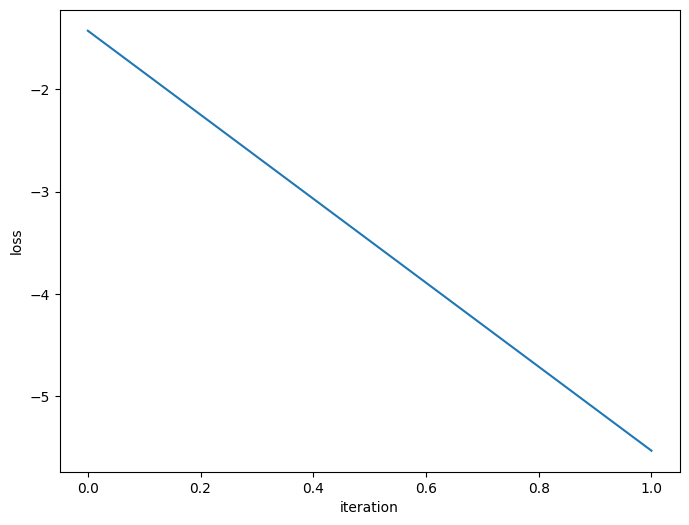

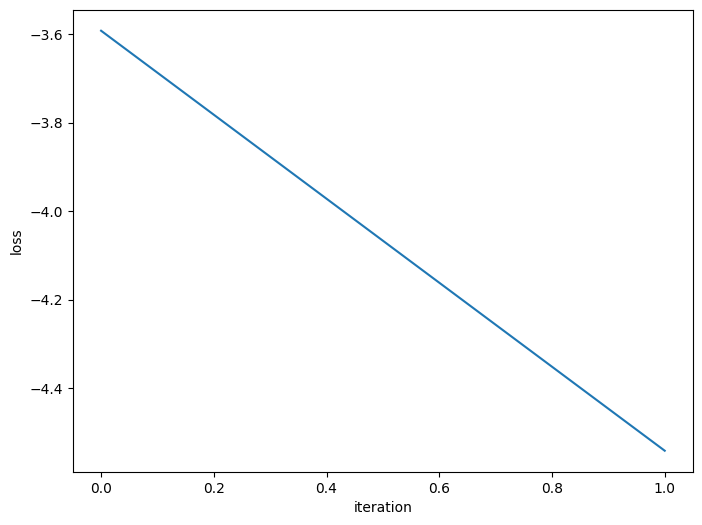

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -910.78015  validloss -859.90158±0.00000  bestvalidloss -859.90158  last_update 0
train: iter 1  trainloss -926.40263  validloss -893.20011±0.00000  bestvalidloss -893.20011  last_update 0
train: iter 2  trainloss -939.95868  validloss -959.61465±0.00000  bestvalidloss -959.61465  last_update 0
train: iter 3  trainloss -918.56630  validloss -912.62808±0.00000  bestvalidloss -959.61465  last_update 1
train: iter 4  trainloss -903.77673  validloss -883.88539±0.00000  bestvalidloss -959.61465  last_update 2
train: iter 5  trainloss -920.95382  validloss -836.17316±0.00000  bestvalidloss -959.61465  last_update 3
train: iter 6  trainloss -952.34110  validloss -934.13253±0.00000  bestvalidloss -959.61465  last_update 4
train: iter 7  trainloss -958.12051  validloss -961.09410±0.00000  bestvalidloss -961.09410  last_update 0
train: iter 8  trainloss -926.13290  validloss -843.10120±0.00000  bestvalidloss -961.09410  last_u

train: iter 76  trainloss -950.72464  validloss -938.93031±0.00000  bestvalidloss -964.83334  last_update 49
train: iter 77  trainloss -948.67312  validloss -919.89100±0.00000  bestvalidloss -964.83334  last_update 50
train: iter 78  trainloss -943.95884  validloss -937.71617±0.00000  bestvalidloss -964.83334  last_update 51
train: iter 79  trainloss -937.68132  validloss -899.54585±0.00000  bestvalidloss -964.83334  last_update 52
train: iter 80  trainloss -962.81154  validloss -912.64213±0.00000  bestvalidloss -964.83334  last_update 53
train: iter 81  trainloss -965.18638  validloss -951.64943±0.00000  bestvalidloss -964.83334  last_update 54
train: iter 82  trainloss -942.64539  validloss -915.00470±0.00000  bestvalidloss -964.83334  last_update 55
train: iter 83  trainloss -968.55982  validloss -929.08811±0.00000  bestvalidloss -964.83334  last_update 56
train: iter 84  trainloss -966.12562  validloss -939.97844±0.00000  bestvalidloss -964.83334  last_update 57
train: iter 85  tra

train: iter 151  trainloss -929.83885  validloss -907.80971±0.00000  bestvalidloss -975.30277  last_update 44
train: iter 152  trainloss -731.18153  validloss -736.26890±0.00000  bestvalidloss -975.30277  last_update 45
train: iter 153  trainloss -897.28837  validloss -837.26197±0.00000  bestvalidloss -975.30277  last_update 46
train: iter 154  trainloss -921.42242  validloss -863.04839±0.00000  bestvalidloss -975.30277  last_update 47
train: iter 155  trainloss -939.20425  validloss -901.66161±0.00000  bestvalidloss -975.30277  last_update 48
train: iter 156  trainloss -944.75709  validloss -880.96212±0.00000  bestvalidloss -975.30277  last_update 49
train: iter 157  trainloss -924.41411  validloss -875.89182±0.00000  bestvalidloss -975.30277  last_update 50
train: iter 158  trainloss -959.55858  validloss -921.61780±0.00000  bestvalidloss -975.30277  last_update 51
train: iter 159  trainloss -941.76215  validloss -932.29702±0.00000  bestvalidloss -975.30277  last_update 52
train: ite

train: iter 226  trainloss -954.68640  validloss -946.57789±0.00000  bestvalidloss -982.01904  last_update 21
train: iter 227  trainloss -922.80114  validloss -887.35718±0.00000  bestvalidloss -982.01904  last_update 22
train: iter 228  trainloss -943.91211  validloss -899.17133±0.00000  bestvalidloss -982.01904  last_update 23
train: iter 229  trainloss -960.39581  validloss -939.46248±0.00000  bestvalidloss -982.01904  last_update 24
train: iter 230  trainloss -950.81884  validloss -976.77363±0.00000  bestvalidloss -982.01904  last_update 25
train: iter 231  trainloss -939.20372  validloss -937.25849±0.00000  bestvalidloss -982.01904  last_update 26
train: iter 232  trainloss -960.68918  validloss -955.10326±0.00000  bestvalidloss -982.01904  last_update 27
train: iter 233  trainloss -952.84834  validloss -905.64199±0.00000  bestvalidloss -982.01904  last_update 28
train: iter 234  trainloss -951.85521  validloss -772.82877±0.00000  bestvalidloss -982.01904  last_update 29
train: ite

train: iter 301  trainloss -873.30333  validloss -785.81422±0.00000  bestvalidloss -982.30128  last_update 59
train: iter 302  trainloss -946.34868  validloss -896.44985±0.00000  bestvalidloss -982.30128  last_update 60
train: iter 303  trainloss -957.20021  validloss -909.29560±0.00000  bestvalidloss -982.30128  last_update 61
train: iter 304  trainloss -967.78866  validloss -931.04728±0.00000  bestvalidloss -982.30128  last_update 62
train: iter 305  trainloss -934.90574  validloss -953.27211±0.00000  bestvalidloss -982.30128  last_update 63
train: iter 306  trainloss -908.56781  validloss -511.93396±0.00000  bestvalidloss -982.30128  last_update 64
train: iter 307  trainloss -922.77018  validloss -914.12887±0.00000  bestvalidloss -982.30128  last_update 65
train: iter 308  trainloss -959.94176  validloss -928.38540±0.00000  bestvalidloss -982.30128  last_update 66
train: iter 309  trainloss -973.07964  validloss -968.27953±0.00000  bestvalidloss -982.30128  last_update 67
train: ite

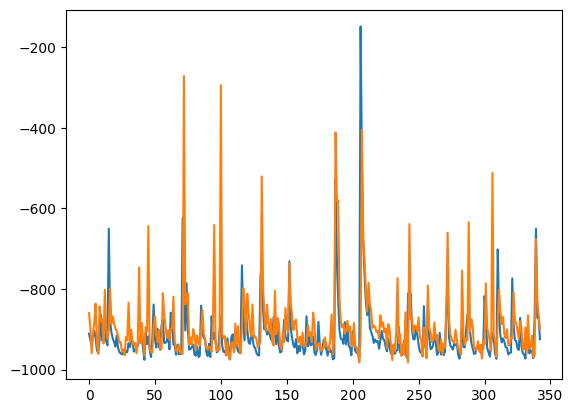

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-11 01:25:11.589692


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69
predict diverge [ -3.94874972  18.00910972 -37.9820478  -33.55588079] [ 0.94131616  0.91079381 -1.48446135 -2.60285845] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 172

 70

 71

 72

 73

 74

 75

 76
predict diverge [ 15.38333189  16.90843708 -54.27851796 -34.0560793 ] [ 0.77245833  0.33503656 -1.45341623 -3.44623511] [113.81023   21.874928 209.19022   32.216457] [ 56.905113  10.937464 104.59511   16.108229] sim_timestep 127

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.56813  validloss 1.06545±0.00000  bestvalidloss 1.06545  last_update 0
train: iter 1  trainloss 0.52100  validloss 0.65510±0.00000  bestvalidloss 0.65510  last_update 0
train: iter 2  trainloss 0.50658  validloss 0.64824±0.00000  bestvalidloss 0.64824  last_update 0
train: iter 3  trainloss 0.50084  validloss 0.61640±0.00000  bestvalidloss 0.61640  last_update 0
train: iter 4  trainloss 0.49261  validloss 0.61649±0.00000  bestvalidloss 0.61640  last_update 1
train: iter 5  trainloss 0.48755  validloss 0.61506±0.00000  bestvalidloss 0.61506  last_update 0
train: iter 6  trainloss 0.48085  validloss 0.60196±0.00000  bestvalidloss 0.60196  last_update 0
train: iter 7  trainloss 0.47701  validloss 0.62028±0.00000  bestvalidloss 0.60196  last_update 1
train: iter 8  trainloss 0.47378  validloss 0.61788±0.00000  bestvalidloss 0.60196  last_update 2
train: iter 9  trainloss 0.47012  validloss 0.59342±0.00000  bestvalidloss 0.59342  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.43182  validloss 0.51949±0.00000  bestvalidloss 0.51189  last_update 17
train: iter 84  trainloss 0.42371  validloss 0.53472±0.00000  bestvalidloss 0.51189  last_update 18
train: iter 85  trainloss 0.42286  validloss 0.53084±0.00000  bestvalidloss 0.51189  last_update 19
train: iter 86  trainloss 0.42496  validloss 0.53395±0.00000  bestvalidloss 0.51189  last_update 20
train: iter 87  trainloss 0.41902  validloss 0.52061±0.00000  bestvalidloss 0.51189  last_update 21
train: iter 88  trainloss 0.42449  validloss 0.53601±0.00000  bestvalidloss 0.51189  last_update 22
train: iter 89  trainloss 0.42258  validloss 0.52198±0.00000  bestvalidloss 0.51189  last_update 23
train: iter 90  trainloss 0.43422  validloss 0.55659±0.00000  bestvalidloss 0.51189  last_update 24
train: iter 91  trainloss 0.41962  validloss 0.53729±0.00000  bestvalidloss 0.51189  last_update 25
train: iter 92  trainloss 0.41937  validloss 0.53133±0.00000  bestvalidloss 0.51189  last_update 26


train: iter 165  trainloss 0.40747  validloss 0.52287±0.00000  bestvalidloss 0.50677  last_update 2
train: iter 166  trainloss 0.40299  validloss 0.52520±0.00000  bestvalidloss 0.50677  last_update 3
train: iter 167  trainloss 0.40449  validloss 0.51265±0.00000  bestvalidloss 0.50677  last_update 4
train: iter 168  trainloss 0.40200  validloss 0.51527±0.00000  bestvalidloss 0.50677  last_update 5
train: iter 169  trainloss 0.39973  validloss 0.53598±0.00000  bestvalidloss 0.50677  last_update 6
train: iter 170  trainloss 0.40370  validloss 0.52244±0.00000  bestvalidloss 0.50677  last_update 7
train: iter 171  trainloss 0.40665  validloss 0.51767±0.00000  bestvalidloss 0.50677  last_update 8
train: iter 172  trainloss 0.41062  validloss 0.53099±0.00000  bestvalidloss 0.50677  last_update 9
train: iter 173  trainloss 0.40415  validloss 0.51618±0.00000  bestvalidloss 0.50677  last_update 10
train: iter 174  trainloss 0.40259  validloss 0.52083±0.00000  bestvalidloss 0.50677  last_update 1

train: iter 247  trainloss 0.38676  validloss 0.51822±0.00000  bestvalidloss 0.50397  last_update 21
train: iter 248  trainloss 0.39470  validloss 0.54137±0.00000  bestvalidloss 0.50397  last_update 22
train: iter 249  trainloss 0.38936  validloss 0.51961±0.00000  bestvalidloss 0.50397  last_update 23
train: iter 250  trainloss 0.39437  validloss 0.52032±0.00000  bestvalidloss 0.50397  last_update 24
train: iter 251  trainloss 0.40768  validloss 0.54111±0.00000  bestvalidloss 0.50397  last_update 25
train: iter 252  trainloss 0.39119  validloss 0.50072±0.00000  bestvalidloss 0.50072  last_update 0
train: iter 253  trainloss 0.38990  validloss 0.51938±0.00000  bestvalidloss 0.50072  last_update 1
train: iter 254  trainloss 0.38876  validloss 0.51933±0.00000  bestvalidloss 0.50072  last_update 2
train: iter 255  trainloss 0.38979  validloss 0.51907±0.00000  bestvalidloss 0.50072  last_update 3
train: iter 256  trainloss 0.39533  validloss 0.51656±0.00000  bestvalidloss 0.50072  last_upda

train: iter 329  trainloss 0.37966  validloss 0.50672±0.00000  bestvalidloss 0.49960  last_update 41
train: iter 330  trainloss 0.38531  validloss 0.53267±0.00000  bestvalidloss 0.49960  last_update 42
train: iter 331  trainloss 0.38088  validloss 0.53045±0.00000  bestvalidloss 0.49960  last_update 43
train: iter 332  trainloss 0.37647  validloss 0.51865±0.00000  bestvalidloss 0.49960  last_update 44
train: iter 333  trainloss 0.38130  validloss 0.51338±0.00000  bestvalidloss 0.49960  last_update 45
train: iter 334  trainloss 0.37996  validloss 0.51484±0.00000  bestvalidloss 0.49960  last_update 46
train: iter 335  trainloss 0.37765  validloss 0.51498±0.00000  bestvalidloss 0.49960  last_update 47
train: iter 336  trainloss 0.37366  validloss 0.51395±0.00000  bestvalidloss 0.49960  last_update 48
train: iter 337  trainloss 0.38215  validloss 0.53497±0.00000  bestvalidloss 0.49960  last_update 49
train: iter 338  trainloss 0.37758  validloss 0.51067±0.00000  bestvalidloss 0.49960  last_

train_loss:  -6.534757867938279
valid_loss:  -8.642819101858139
weight_alpha 1.0 h_min_tilde -11.778737 ell_tilde -6.956370114722251 kappa_tilde 0.0002276878609530511
train_loss:  -4.7160250209331505
valid_loss:  -4.7169873274922365
weight_alpha 0.1 h_min_tilde -11.778737 ell_tilde -4.716217482244968 kappa_tilde 0.0001881439127938031


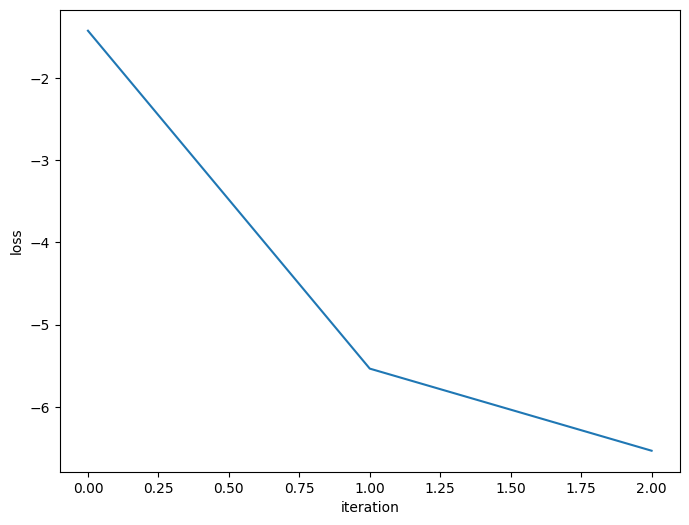

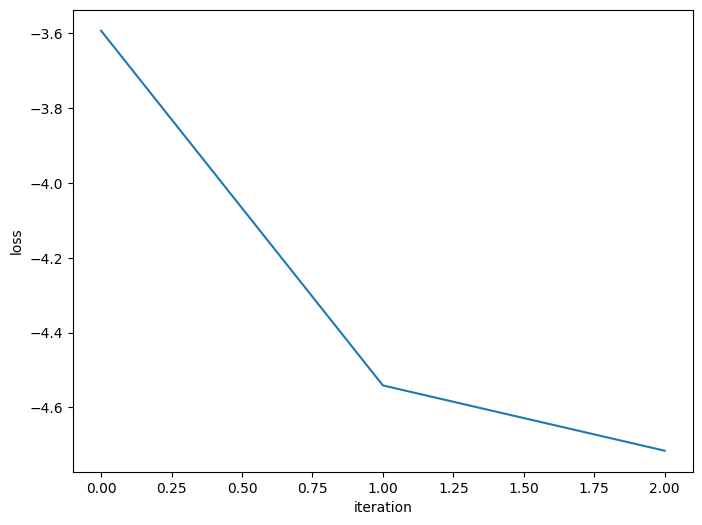

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -955.70330  validloss -945.96979±0.00000  bestvalidloss -945.96979  last_update 0
train: iter 1  trainloss -965.18238  validloss -968.63396±0.00000  bestvalidloss -968.63396  last_update 0
train: iter 2  trainloss -932.21438  validloss -980.13271±0.00000  bestvalidloss -980.13271  last_update 0
train: iter 3  trainloss -976.79526  validloss -936.98725±0.00000  bestvalidloss -980.13271  last_update 1
train: iter 4  trainloss -938.90811  validloss -956.23993±0.00000  bestvalidloss -980.13271  last_update 2
train: iter 5  trainloss -979.39305  validloss -943.02418±0.00000  bestvalidloss -980.13271  last_update 3
train: iter 6  trainloss -984.38234  validloss -974.24712±0.00000  bestvalidloss -980.13271  last_update 4
train: iter 7  trainloss -944.33678  validloss -980.31061±0.00000  bestvalidloss -980.31061  last_update 0
train: iter 8  trainloss -959.52679  validloss -862.64583±0.00000  bestvalidloss -980.31061  last_u

train: iter 75  trainloss -977.22707  validloss -974.77362±0.00000  bestvalidloss -1003.88362  last_update 19
train: iter 76  trainloss -991.65007  validloss -985.11431±0.00000  bestvalidloss -1003.88362  last_update 20
train: iter 77  trainloss -982.97770  validloss -972.84724±0.00000  bestvalidloss -1003.88362  last_update 21
train: iter 78  trainloss -993.54089  validloss -989.50907±0.00000  bestvalidloss -1003.88362  last_update 22
train: iter 79  trainloss -981.06583  validloss -979.78542±0.00000  bestvalidloss -1003.88362  last_update 23
train: iter 80  trainloss -982.61780  validloss -977.42570±0.00000  bestvalidloss -1003.88362  last_update 24
train: iter 81  trainloss -925.79020  validloss -956.34979±0.00000  bestvalidloss -1003.88362  last_update 25
train: iter 82  trainloss -970.59392  validloss -950.91055±0.00000  bestvalidloss -1003.88362  last_update 26
train: iter 83  trainloss -975.37881  validloss -959.88683±0.00000  bestvalidloss -1003.88362  last_update 27
train: ite

train: iter 150  trainloss -984.42906  validloss -995.72870±0.00000  bestvalidloss -1013.05728  last_update 48
train: iter 151  trainloss -965.78366  validloss -993.18869±0.00000  bestvalidloss -1013.05728  last_update 49
train: iter 152  trainloss -971.97384  validloss -949.86346±0.00000  bestvalidloss -1013.05728  last_update 50
train: iter 153  trainloss -993.64305  validloss -997.75894±0.00000  bestvalidloss -1013.05728  last_update 51
train: iter 154  trainloss -937.25449  validloss -882.07246±0.00000  bestvalidloss -1013.05728  last_update 52
train: iter 155  trainloss -950.85765  validloss -837.32080±0.00000  bestvalidloss -1013.05728  last_update 53
train: iter 156  trainloss -981.16450  validloss -969.99466±0.00000  bestvalidloss -1013.05728  last_update 54
train: iter 157  trainloss -979.88962  validloss -987.50016±0.00000  bestvalidloss -1013.05728  last_update 55
train: iter 158  trainloss -924.74815  validloss -975.56742±0.00000  bestvalidloss -1013.05728  last_update 56
t

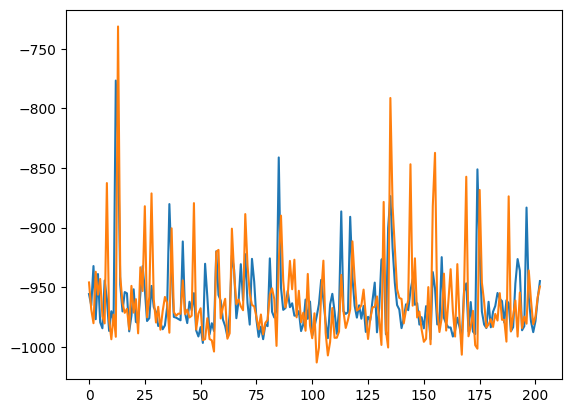

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-11 01:58:46.928101


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.51667  validloss 0.74697±0.00000  bestvalidloss 0.74697  last_update 0
train: iter 1  trainloss 0.47112  validloss 0.58571±0.00000  bestvalidloss 0.58571  last_update 0
train: iter 2  trainloss 0.45649  validloss 0.56716±0.00000  bestvalidloss 0.56716  last_update 0
train: iter 3  trainloss 0.45249  validloss 0.56221±0.00000  bestvalidloss 0.56221  last_update 0
train: iter 4  trainloss 0.44238  validloss 0.55043±0.00000  bestvalidloss 0.55043  last_update 0
train: iter 5  trainloss 0.43795  validloss 0.55357±0.00000  bestvalidloss 0.55043  last_update 1
train: iter 6  trainloss 0.44151  validloss 0.55629±0.00000  bestvalidloss 0.55043  last_update 2
train: iter 7  trainloss 0.43672  validloss 0.54150±0.00000  bestvalidloss 0.54150  last_update 0
train: iter 8  trainloss 0.43304  validloss 0.54230±0.00000  bestvalidloss 0.54150  last_update 1
train: iter 9  trainloss 0.42863  validloss 0.52979±0.00000  bestvalidloss 0.52979  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.39891  validloss 0.52859±0.00000  bestvalidloss 0.51230  last_update 3
train: iter 84  trainloss 0.39792  validloss 0.52005±0.00000  bestvalidloss 0.51230  last_update 4
train: iter 85  trainloss 0.39900  validloss 0.53015±0.00000  bestvalidloss 0.51230  last_update 5
train: iter 86  trainloss 0.39893  validloss 0.50656±0.00000  bestvalidloss 0.50656  last_update 0
train: iter 87  trainloss 0.40263  validloss 0.52440±0.00000  bestvalidloss 0.50656  last_update 1
train: iter 88  trainloss 0.39555  validloss 0.51781±0.00000  bestvalidloss 0.50656  last_update 2
train: iter 89  trainloss 0.39419  validloss 0.52158±0.00000  bestvalidloss 0.50656  last_update 3
train: iter 90  trainloss 0.39571  validloss 0.52871±0.00000  bestvalidloss 0.50656  last_update 4
train: iter 91  trainloss 0.39855  validloss 0.53157±0.00000  bestvalidloss 0.50656  last_update 5
train: iter 92  trainloss 0.39357  validloss 0.55086±0.00000  bestvalidloss 0.50656  last_update 6
train: ite

train: iter 165  trainloss 0.38949  validloss 0.51715±0.00000  bestvalidloss 0.50632  last_update 35
train: iter 166  trainloss 0.38235  validloss 0.52076±0.00000  bestvalidloss 0.50632  last_update 36
train: iter 167  trainloss 0.38331  validloss 0.52849±0.00000  bestvalidloss 0.50632  last_update 37
train: iter 168  trainloss 0.38211  validloss 0.53186±0.00000  bestvalidloss 0.50632  last_update 38
train: iter 169  trainloss 0.38560  validloss 0.51623±0.00000  bestvalidloss 0.50632  last_update 39
train: iter 170  trainloss 0.38330  validloss 0.52280±0.00000  bestvalidloss 0.50632  last_update 40
train: iter 171  trainloss 0.38146  validloss 0.52588±0.00000  bestvalidloss 0.50632  last_update 41
train: iter 172  trainloss 0.38405  validloss 0.52080±0.00000  bestvalidloss 0.50632  last_update 42
train: iter 173  trainloss 0.37839  validloss 0.53065±0.00000  bestvalidloss 0.50632  last_update 43
train: iter 174  trainloss 0.37883  validloss 0.52166±0.00000  bestvalidloss 0.50632  last_

train_loss:  -4.435403166437149
valid_loss:  -5.622094031572342
weight_alpha 1.0 h_min_tilde -11.843934 ell_tilde -4.672741339464188 kappa_tilde 0.0001867128926721282
train_loss:  -4.354386560678483
valid_loss:  -4.261335020065308
weight_alpha 0.1 h_min_tilde -11.843934 ell_tilde -4.335776252555848 kappa_tilde 0.00018247497310382648


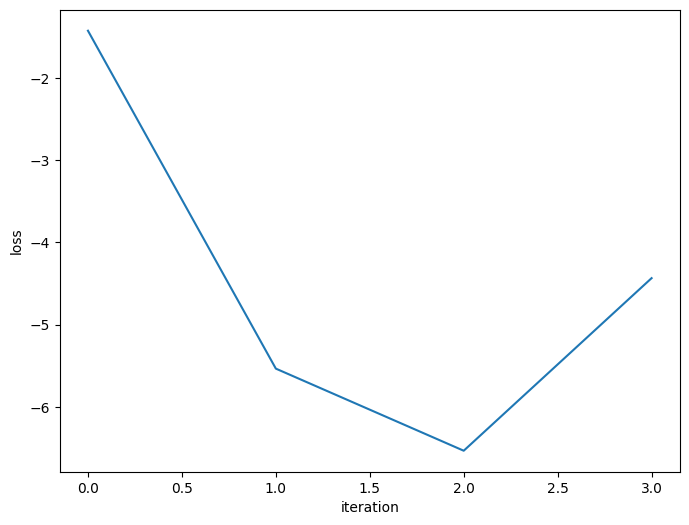

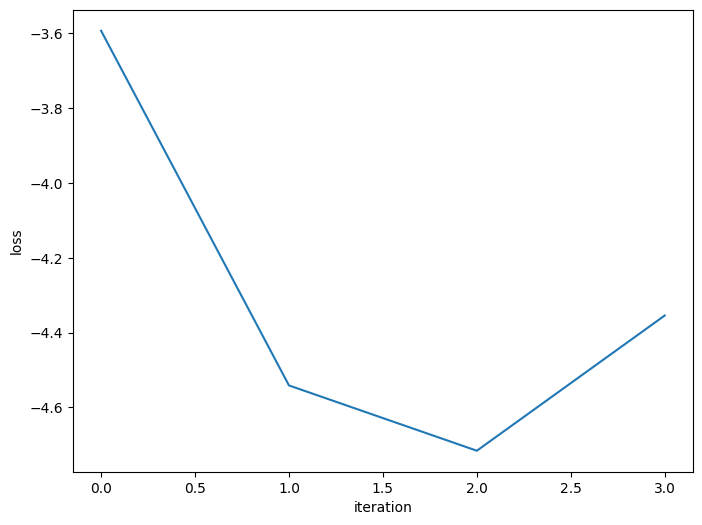

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -895.19858  validloss -853.41405±0.00000  bestvalidloss -853.41405  last_update 0
train: iter 1  trainloss -865.07284  validloss -906.76975±0.00000  bestvalidloss -906.76975  last_update 0
train: iter 2  trainloss -899.84569  validloss -846.67192±0.00000  bestvalidloss -906.76975  last_update 1
train: iter 3  trainloss -893.96588  validloss -889.08792±0.00000  bestvalidloss -906.76975  last_update 2
train: iter 4  trainloss -910.21533  validloss -901.38295±0.00000  bestvalidloss -906.76975  last_update 3
train: iter 5  trainloss -892.81800  validloss -914.51287±0.00000  bestvalidloss -914.51287  last_update 0
train: iter 6  trainloss -900.56042  validloss -899.86431±0.00000  bestvalidloss -914.51287  last_update 1
train: iter 7  trainloss -886.92082  validloss -888.33254±0.00000  bestvalidloss -914.51287  last_update 2
train: iter 8  trainloss -905.78197  validloss -888.59999±0.00000  bestvalidloss -914.51287  last_u

train: iter 76  trainloss -895.46684  validloss -890.97983±0.00000  bestvalidloss -928.31576  last_update 5
train: iter 77  trainloss -912.76417  validloss -917.25831±0.00000  bestvalidloss -928.31576  last_update 6
train: iter 78  trainloss -905.41330  validloss -923.49470±0.00000  bestvalidloss -928.31576  last_update 7
train: iter 79  trainloss -898.82903  validloss -912.97819±0.00000  bestvalidloss -928.31576  last_update 8
train: iter 80  trainloss -903.38746  validloss -904.09051±0.00000  bestvalidloss -928.31576  last_update 9
train: iter 81  trainloss -899.12108  validloss -909.53134±0.00000  bestvalidloss -928.31576  last_update 10
train: iter 82  trainloss -908.86116  validloss -873.78242±0.00000  bestvalidloss -928.31576  last_update 11
train: iter 83  trainloss -917.69905  validloss -905.07892±0.00000  bestvalidloss -928.31576  last_update 12
train: iter 84  trainloss -815.45009  validloss -925.32384±0.00000  bestvalidloss -928.31576  last_update 13
train: iter 85  trainlos

train: iter 151  trainloss -810.67298  validloss -819.75553±0.00000  bestvalidloss -937.27249  last_update 48
train: iter 152  trainloss -907.31274  validloss -894.47529±0.00000  bestvalidloss -937.27249  last_update 49
train: iter 153  trainloss -901.71345  validloss -901.68243±0.00000  bestvalidloss -937.27249  last_update 50
train: iter 154  trainloss -896.56993  validloss -863.97378±0.00000  bestvalidloss -937.27249  last_update 51
train: iter 155  trainloss -909.85171  validloss -908.75863±0.00000  bestvalidloss -937.27249  last_update 52
train: iter 156  trainloss -922.11915  validloss -916.22359±0.00000  bestvalidloss -937.27249  last_update 53
train: iter 157  trainloss -896.28361  validloss -906.26512±0.00000  bestvalidloss -937.27249  last_update 54
train: iter 158  trainloss -914.26137  validloss -915.81004±0.00000  bestvalidloss -937.27249  last_update 55
train: iter 159  trainloss -916.70142  validloss -904.30380±0.00000  bestvalidloss -937.27249  last_update 56
train: ite

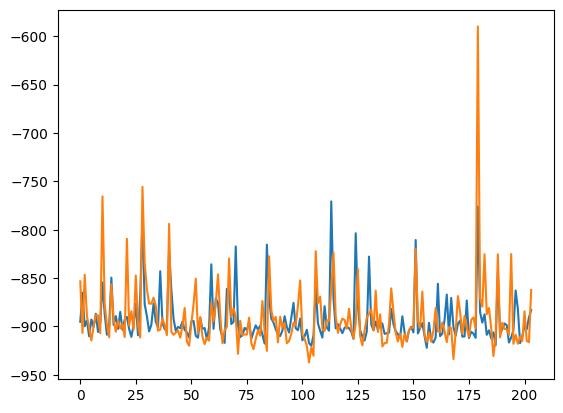

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-11 02:31:22.662648


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.50738  validloss 1.01486±0.00000  bestvalidloss 1.01486  last_update 0
train: iter 1  trainloss 0.47143  validloss 0.59864±0.00000  bestvalidloss 0.59864  last_update 0
train: iter 2  trainloss 0.46278  validloss 0.57720±0.00000  bestvalidloss 0.57720  last_update 0
train: iter 3  trainloss 0.45478  validloss 0.60111±0.00000  bestvalidloss 0.57720  last_update 1
train: iter 4  trainloss 0.45723  validloss 0.59420±0.00000  bestvalidloss 0.57720  last_update 2
train: iter 5  trainloss 0.44859  validloss 0.59680±0.00000  bestvalidloss 0.57720  last_update 3
train: iter 6  trainloss 0.44342  validloss 0.57177±0.00000  bestvalidloss 0.57177  last_update 0
train: iter 7  trainloss 0.44602  validloss 0.59380±0.00000  bestvalidloss 0.57177  last_update 1
train: iter 8  trainloss 0.44337  validloss 0.60111±0.00000  bestvalidloss 0.57177  last_update 2
train: iter 9  trainloss 0.44078  validloss 0.59261±0.00000  bestvalidloss 0.57177  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.41676  validloss 0.57981±0.00000  bestvalidloss 0.56116  last_update 41
train: iter 84  trainloss 0.41172  validloss 0.57519±0.00000  bestvalidloss 0.56116  last_update 42
train: iter 85  trainloss 0.41148  validloss 0.59589±0.00000  bestvalidloss 0.56116  last_update 43
train: iter 86  trainloss 0.41059  validloss 0.59047±0.00000  bestvalidloss 0.56116  last_update 44
train: iter 87  trainloss 0.41467  validloss 0.60318±0.00000  bestvalidloss 0.56116  last_update 45
train: iter 88  trainloss 0.41669  validloss 0.60757±0.00000  bestvalidloss 0.56116  last_update 46
train: iter 89  trainloss 0.41188  validloss 0.63833±0.00000  bestvalidloss 0.56116  last_update 47
train: iter 90  trainloss 0.41284  validloss 0.60236±0.00000  bestvalidloss 0.56116  last_update 48
train: iter 91  trainloss 0.41420  validloss 0.57574±0.00000  bestvalidloss 0.56116  last_update 49
train: iter 92  trainloss 0.41058  validloss 0.57771±0.00000  bestvalidloss 0.56116  last_update 50


train_loss:  -6.979838498517871
valid_loss:  -9.740234556770325
weight_alpha 1.0 h_min_tilde -11.925463 ell_tilde -7.531917710168362 kappa_tilde 0.00023854068620523259
train_loss:  -5.181025539827347
valid_loss:  -5.143369355773926
weight_alpha 0.1 h_min_tilde -11.925463 ell_tilde -5.173494303016663 kappa_tilde 0.00019242203493533084


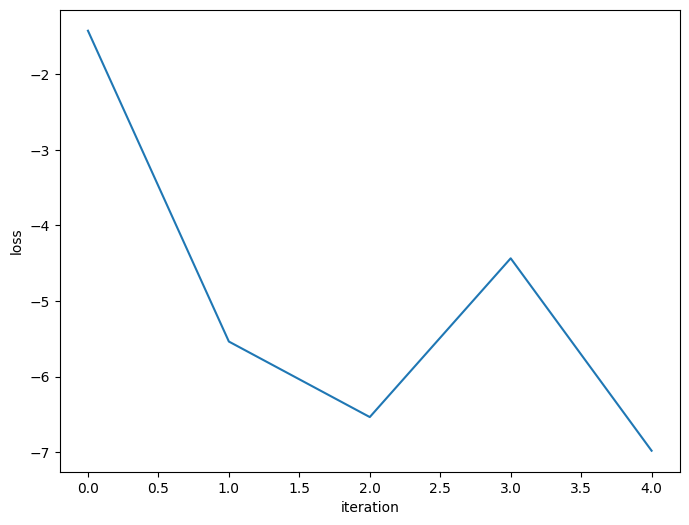

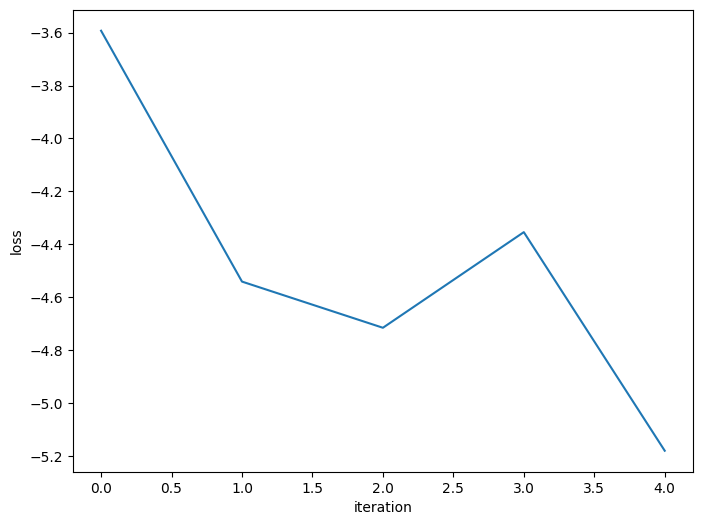

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -1037.83072  validloss -1024.98521±0.00000  bestvalidloss -1024.98521  last_update 0
train: iter 1  trainloss -1047.62837  validloss -1039.57428±0.00000  bestvalidloss -1039.57428  last_update 0
train: iter 2  trainloss -1031.08333  validloss -1051.43906±0.00000  bestvalidloss -1051.43906  last_update 0
train: iter 3  trainloss -1023.81430  validloss -952.63272±0.00000  bestvalidloss -1051.43906  last_update 1
train: iter 4  trainloss -1046.96611  validloss -1037.07766±0.00000  bestvalidloss -1051.43906  last_update 2
train: iter 5  trainloss -964.41306  validloss -1038.06623±0.00000  bestvalidloss -1051.43906  last_update 3
train: iter 6  trainloss -981.88427  validloss -175.15737±0.00000  bestvalidloss -1051.43906  last_update 4
train: iter 7  trainloss -1007.83921  validloss -1017.14799±0.00000  bestvalidloss -1051.43906  last_update 5
train: iter 8  trainloss -1045.13447  validloss -1020.78915±0.00000  bestvalidl

train: iter 74  trainloss -1045.74447  validloss -1027.54682±0.00000  bestvalidloss -1053.70917  last_update 25
train: iter 75  trainloss -1052.73654  validloss -957.39269±0.00000  bestvalidloss -1053.70917  last_update 26
train: iter 76  trainloss -1061.62260  validloss -1053.38531±0.00000  bestvalidloss -1053.70917  last_update 27
train: iter 77  trainloss -1037.95410  validloss -993.96257±0.00000  bestvalidloss -1053.70917  last_update 28
train: iter 78  trainloss -1061.64254  validloss -1045.09889±0.00000  bestvalidloss -1053.70917  last_update 29
train: iter 79  trainloss -1017.27346  validloss -1019.45348±0.00000  bestvalidloss -1053.70917  last_update 30
train: iter 80  trainloss -1053.41790  validloss -1012.27384±0.00000  bestvalidloss -1053.70917  last_update 31
train: iter 81  trainloss -1034.51685  validloss -1014.36298±0.00000  bestvalidloss -1053.70917  last_update 32
train: iter 82  trainloss -1061.53053  validloss -1032.30105±0.00000  bestvalidloss -1053.70917  last_upda

train: iter 148  trainloss -1014.45794  validloss -977.16060±0.00000  bestvalidloss -1057.11271  last_update 50
train: iter 149  trainloss -1017.42868  validloss -951.25337±0.00000  bestvalidloss -1057.11271  last_update 51
train: iter 150  trainloss -1044.11512  validloss -1001.98321±0.00000  bestvalidloss -1057.11271  last_update 52
train: iter 151  trainloss -1045.71728  validloss -979.59939±0.00000  bestvalidloss -1057.11271  last_update 53
train: iter 152  trainloss -1052.56893  validloss -999.92809±0.00000  bestvalidloss -1057.11271  last_update 54
train: iter 153  trainloss -1067.07863  validloss -1023.64471±0.00000  bestvalidloss -1057.11271  last_update 55
train: iter 154  trainloss -1028.40694  validloss -1042.23955±0.00000  bestvalidloss -1057.11271  last_update 56
train: iter 155  trainloss -1044.66642  validloss -987.18346±0.00000  bestvalidloss -1057.11271  last_update 57
train: iter 156  trainloss -1055.79894  validloss -1021.30445±0.00000  bestvalidloss -1057.11271  las

train: iter 221  trainloss -1031.36122  validloss -1034.84681±0.00000  bestvalidloss -1063.96645  last_update 42
train: iter 222  trainloss -1035.05691  validloss -972.61477±0.00000  bestvalidloss -1063.96645  last_update 43
train: iter 223  trainloss -1068.48660  validloss -1016.22966±0.00000  bestvalidloss -1063.96645  last_update 44
train: iter 224  trainloss -949.87133  validloss -963.70623±0.00000  bestvalidloss -1063.96645  last_update 45
train: iter 225  trainloss -937.11346  validloss -868.51345±0.00000  bestvalidloss -1063.96645  last_update 46
train: iter 226  trainloss -1037.53690  validloss -976.70643±0.00000  bestvalidloss -1063.96645  last_update 47
train: iter 227  trainloss -997.72706  validloss -997.67478±0.00000  bestvalidloss -1063.96645  last_update 48
train: iter 228  trainloss -1042.24070  validloss -981.77447±0.00000  bestvalidloss -1063.96645  last_update 49
train: iter 229  trainloss -1054.37289  validloss -994.60228±0.00000  bestvalidloss -1063.96645  last_upd

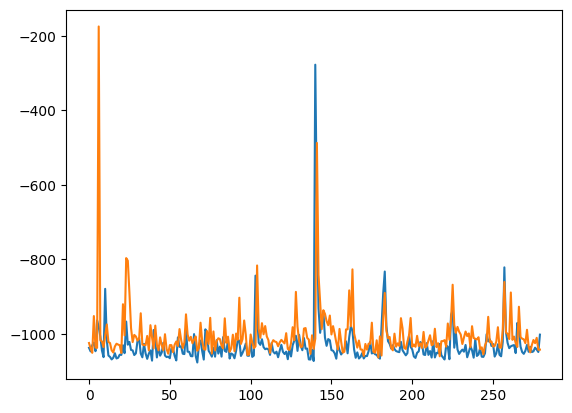

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-11 03:03:37.046574


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47118  validloss 0.68510±0.00000  bestvalidloss 0.68510  last_update 0
train: iter 1  trainloss 0.45250  validloss 0.57151±0.00000  bestvalidloss 0.57151  last_update 0
train: iter 2  trainloss 0.44916  validloss 0.53323±0.00000  bestvalidloss 0.53323  last_update 0
train: iter 3  trainloss 0.44508  validloss 0.56668±0.00000  bestvalidloss 0.53323  last_update 1
train: iter 4  trainloss 0.43939  validloss 0.53656±0.00000  bestvalidloss 0.53323  last_update 2
train: iter 5  trainloss 0.44658  validloss 0.52029±0.00000  bestvalidloss 0.52029  last_update 0
train: iter 6  trainloss 0.43547  validloss 0.53911±0.00000  bestvalidloss 0.52029  last_update 1
train: iter 7  trainloss 0.43322  validloss 0.53914±0.00000  bestvalidloss 0.52029  last_update 2
train: iter 8  trainloss 0.42703  validloss 0.54789±0.00000  bestvalidloss 0.52029  last_update 3
train: iter 9  trainloss 0.43893  validloss 0.53113±0.00000  bestvalidloss 0.52029  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.40170  validloss 0.50241±0.00000  bestvalidloss 0.49880  last_update 37
train: iter 84  trainloss 0.40471  validloss 0.50823±0.00000  bestvalidloss 0.49880  last_update 38
train: iter 85  trainloss 0.39996  validloss 0.53725±0.00000  bestvalidloss 0.49880  last_update 39
train: iter 86  trainloss 0.40380  validloss 0.51675±0.00000  bestvalidloss 0.49880  last_update 40
train: iter 87  trainloss 0.39901  validloss 0.50963±0.00000  bestvalidloss 0.49880  last_update 41
train: iter 88  trainloss 0.40243  validloss 0.52481±0.00000  bestvalidloss 0.49880  last_update 42
train: iter 89  trainloss 0.39840  validloss 0.52991±0.00000  bestvalidloss 0.49880  last_update 43
train: iter 90  trainloss 0.39766  validloss 0.50793±0.00000  bestvalidloss 0.49880  last_update 44
train: iter 91  trainloss 0.39531  validloss 0.51327±0.00000  bestvalidloss 0.49880  last_update 45
train: iter 92  trainloss 0.39601  validloss 0.53291±0.00000  bestvalidloss 0.49880  last_update 46


train: iter 165  trainloss 0.38370  validloss 0.51752±0.00000  bestvalidloss 0.49335  last_update 62
train: iter 166  trainloss 0.38129  validloss 0.52835±0.00000  bestvalidloss 0.49335  last_update 63
train: iter 167  trainloss 0.39228  validloss 0.53345±0.00000  bestvalidloss 0.49335  last_update 64
train: iter 168  trainloss 0.38638  validloss 0.51342±0.00000  bestvalidloss 0.49335  last_update 65
train: iter 169  trainloss 0.38801  validloss 0.51307±0.00000  bestvalidloss 0.49335  last_update 66
train: iter 170  trainloss 0.38934  validloss 0.52190±0.00000  bestvalidloss 0.49335  last_update 67
train: iter 171  trainloss 0.38521  validloss 0.53262±0.00000  bestvalidloss 0.49335  last_update 68
train: iter 172  trainloss 0.38287  validloss 0.55019±0.00000  bestvalidloss 0.49335  last_update 69
train: iter 173  trainloss 0.38390  validloss 0.52495±0.00000  bestvalidloss 0.49335  last_update 70
train: iter 174  trainloss 0.38228  validloss 0.51995±0.00000  bestvalidloss 0.49335  last_

([0.47118138764053585,
  0.45250101387500763,
  0.4491553165949881,
  0.44508389886468647,
  0.4393906328827143,
  0.44657535273581744,
  0.4354679001495242,
  0.4332222258672118,
  0.4270279464311898,
  0.43893209509551523,
  0.431633304618299,
  0.429934149235487,
  0.437669375911355,
  0.4267925344407558,
  0.42677900809794667,
  0.42636790238320826,
  0.42318738494068386,
  0.4227518443018198,
  0.41998877804726364,
  0.42641955353319644,
  0.4193839056417346,
  0.41904661152511835,
  0.4218247411772609,
  0.41737503428012135,
  0.4234941378235817,
  0.4214352985844016,
  0.420049406029284,
  0.4153197053819895,
  0.4201320832595229,
  0.4152839815244079,
  0.4119499607011676,
  0.41882554776966574,
  0.4199145704507828,
  0.41290000844746827,
  0.41697293762117627,
  0.41867696680128574,
  0.4147421855479479,
  0.4143905334174633,
  0.41102966144680975,
  0.4087623143568635,
  0.415136312879622,
  0.41343475971370935,
  0.4116591766476631,
  0.4109356730245054,
  0.407438084296882

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.310796421426534
valid_loss:  -7.62720021159649
weight_alpha 1.0 h_min_tilde -11.975023 ell_tilde -6.5740771794605255 kappa_tilde 0.0002151468952103349
train_loss:  -5.01436249871254
valid_loss:  -4.860768188500405
weight_alpha 0.1 h_min_tilde -11.975023 ell_tilde -4.983643636670113 kappa_tilde 0.0001890987081071077


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 27.60264  validloss 30.26159±0.00000  bestvalidloss 30.26159  last_update 0
train: iter 1  trainloss 22.68143  validloss 24.51452±0.00000  bestvalidloss 24.51452  last_update 0
train: iter 2  trainloss 18.91753  validloss 20.26109±0.00000  bestvalidloss 20.26109  last_update 0
train: iter 3  trainloss 15.56692  validloss 16.94776±0.00000  bestvalidloss 16.94776  last_update 0
train: iter 4  trainloss 13.27131  validloss 14.32638±0.00000  bestvalidloss 14.32638  last_update 0
train: iter 5  trainloss 11.20375  validloss 11.95526±0.00000  bestvalidloss 11.95526  last_update 0
train: iter 6  trainloss 9.51455  validloss 10.13859±0.00000  bestvalidloss 10.13859  last_update 0
train: iter 7  trainloss 8.15235  validloss 8.61566±0.00000  bestvalidloss 8.61566  last_update 0
train: iter 8  trainloss 6.99541  validloss 7.35705±0.00000  bestvalidloss 7.35705  last_update 0
train: iter 9  trainloss 6.00783  validloss 6.22958±0.00000  bestvalidloss 6.22958  last_update 0


train: iter 86  trainloss -0.22041  validloss -0.28913±0.00000  bestvalidloss -0.28913  last_update 0
train: iter 87  trainloss -0.24209  validloss -0.32047±0.00000  bestvalidloss -0.32047  last_update 0
train: iter 88  trainloss -0.24511  validloss -0.34773±0.00000  bestvalidloss -0.34773  last_update 0
train: iter 89  trainloss -0.24404  validloss -0.34073±0.00000  bestvalidloss -0.34773  last_update 1
train: iter 90  trainloss -0.25714  validloss -0.36126±0.00000  bestvalidloss -0.36126  last_update 0
train: iter 91  trainloss -0.27204  validloss -0.33753±0.00000  bestvalidloss -0.36126  last_update 1
train: iter 92  trainloss -0.29430  validloss -0.36294±0.00000  bestvalidloss -0.36294  last_update 0
train: iter 93  trainloss -0.28822  validloss -0.44592±0.00000  bestvalidloss -0.44592  last_update 0
train: iter 94  trainloss -0.30642  validloss -0.38723±0.00000  bestvalidloss -0.44592  last_update 1
train: iter 95  trainloss -0.29917  validloss -0.39690±0.00000  bestvalidloss -0.4

train: iter 178  trainloss -0.38773  validloss -0.64031±0.00000  bestvalidloss -0.66936  last_update 23
train: iter 179  trainloss -0.40491  validloss -0.57801±0.00000  bestvalidloss -0.66936  last_update 24
train: iter 180  trainloss -0.48174  validloss -0.60706±0.00000  bestvalidloss -0.66936  last_update 25
train: iter 181  trainloss -0.40394  validloss -0.59810±0.00000  bestvalidloss -0.66936  last_update 26
train: iter 182  trainloss -0.43942  validloss -0.50655±0.00000  bestvalidloss -0.66936  last_update 27
train: iter 183  trainloss -0.38269  validloss -0.52802±0.00000  bestvalidloss -0.66936  last_update 28
train: iter 184  trainloss -0.41981  validloss -0.60720±0.00000  bestvalidloss -0.66936  last_update 29
train: iter 185  trainloss -0.43609  validloss -0.57447±0.00000  bestvalidloss -0.66936  last_update 30
train: iter 186  trainloss -0.41095  validloss -0.52156±0.00000  bestvalidloss -0.66936  last_update 31
train: iter 187  trainloss -0.44203  validloss -0.32752±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.9884, -0.1366, -5.3310, -1.1817], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 11.04929  validloss 14.28829±0.00000  bestvalidloss 14.28829  last_update 0
train: iter 1  trainloss 9.84503  validloss 12.46795±0.00000  bestvalidloss 12.46795  last_update 0
train: iter 2  trainloss 9.58533  validloss 11.83646±0.00000  bestvalidloss 11.83646  last_update 0
train: iter 3  trainloss 9.48433  validloss 11.87685±0.00000  bestvalidloss 11.83646  last_update 1
train: iter 4  trainloss 9.46159  validloss 11.62863±0.00000  bestvalidloss 11.62863  last_update 0
train: iter 5  trainloss 9.36994  validloss 11.51616±0.00000  bestvalidloss 11.51616  last_update 0
train: iter 6  trainloss 9.31845  validloss 11.21351±0.00000  bestvalidloss 11.21351  last_update 0
train: iter 7  trainloss 9.31448  validloss 10.91766±0.00000  bestvalidloss 10.91766  last_update 0
train: iter 8  trainloss 9.26803  validloss 11.68508±0.00000  bestvalidloss 10.91766  last_update 1
train: iter 9  trainloss 9.14858  validloss 11.61881±0.00000  bestvalidloss 10.91766  last_update 2

train: iter 83  trainloss 8.46770  validloss 10.75225±0.00000  bestvalidloss 10.26972  last_update 7
train: iter 84  trainloss 8.37281  validloss 11.30408±0.00000  bestvalidloss 10.26972  last_update 8
train: iter 85  trainloss 8.43396  validloss 11.25234±0.00000  bestvalidloss 10.26972  last_update 9
train: iter 86  trainloss 8.41348  validloss 11.16195±0.00000  bestvalidloss 10.26972  last_update 10
train: iter 87  trainloss 8.35487  validloss 10.84217±0.00000  bestvalidloss 10.26972  last_update 11
train: iter 88  trainloss 8.36688  validloss 10.70923±0.00000  bestvalidloss 10.26972  last_update 12
train: iter 89  trainloss 8.37101  validloss 11.20809±0.00000  bestvalidloss 10.26972  last_update 13
train: iter 90  trainloss 8.36238  validloss 11.14616±0.00000  bestvalidloss 10.26972  last_update 14
train: iter 91  trainloss 8.44441  validloss 10.96174±0.00000  bestvalidloss 10.26972  last_update 15
train: iter 92  trainloss 8.38105  validloss 10.72534±0.00000  bestvalidloss 10.26972

train: iter 163  trainloss 8.17487  validloss 10.80169±0.00000  bestvalidloss 10.26972  last_update 87
train: iter 164  trainloss 8.21654  validloss 10.63888±0.00000  bestvalidloss 10.26972  last_update 88
train: iter 165  trainloss 8.24729  validloss 11.23687±0.00000  bestvalidloss 10.26972  last_update 89
train: iter 166  trainloss 8.19296  validloss 11.38606±0.00000  bestvalidloss 10.26972  last_update 90
train: iter 167  trainloss 8.17649  validloss 10.81266±0.00000  bestvalidloss 10.26972  last_update 91
train: iter 168  trainloss 8.17258  validloss 11.24062±0.00000  bestvalidloss 10.26972  last_update 92
train: iter 169  trainloss 8.18647  validloss 11.02865±0.00000  bestvalidloss 10.26972  last_update 93
train: iter 170  trainloss 8.12865  validloss 11.40016±0.00000  bestvalidloss 10.26972  last_update 94
train: iter 171  trainloss 8.17993  validloss 10.40862±0.00000  bestvalidloss 10.26972  last_update 95
train: iter 172  trainloss 8.13215  validloss 10.55044±0.00000  bestvalid

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.6377)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(9.8549)


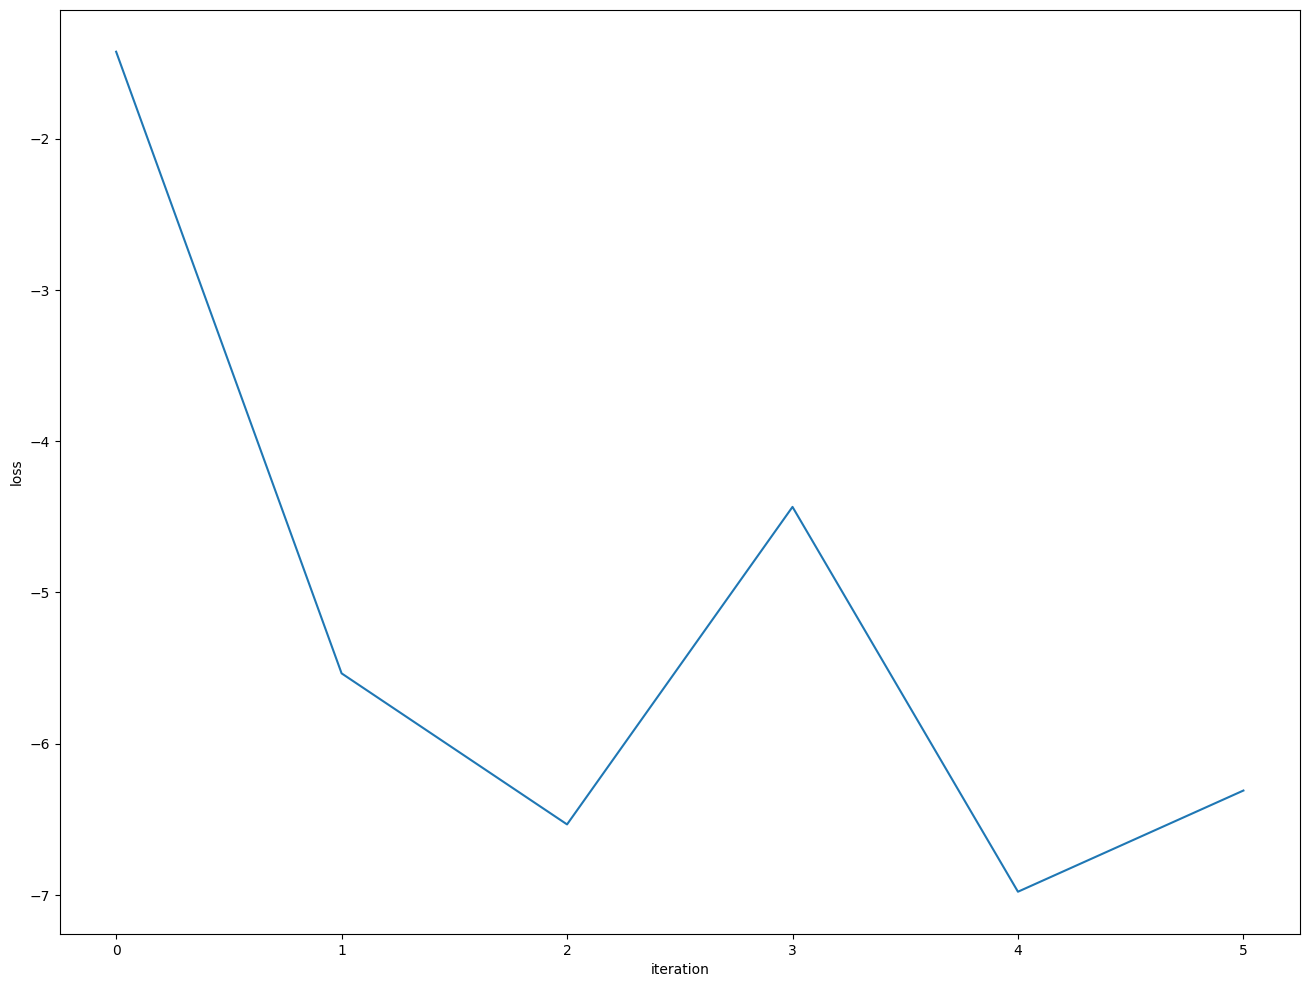

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

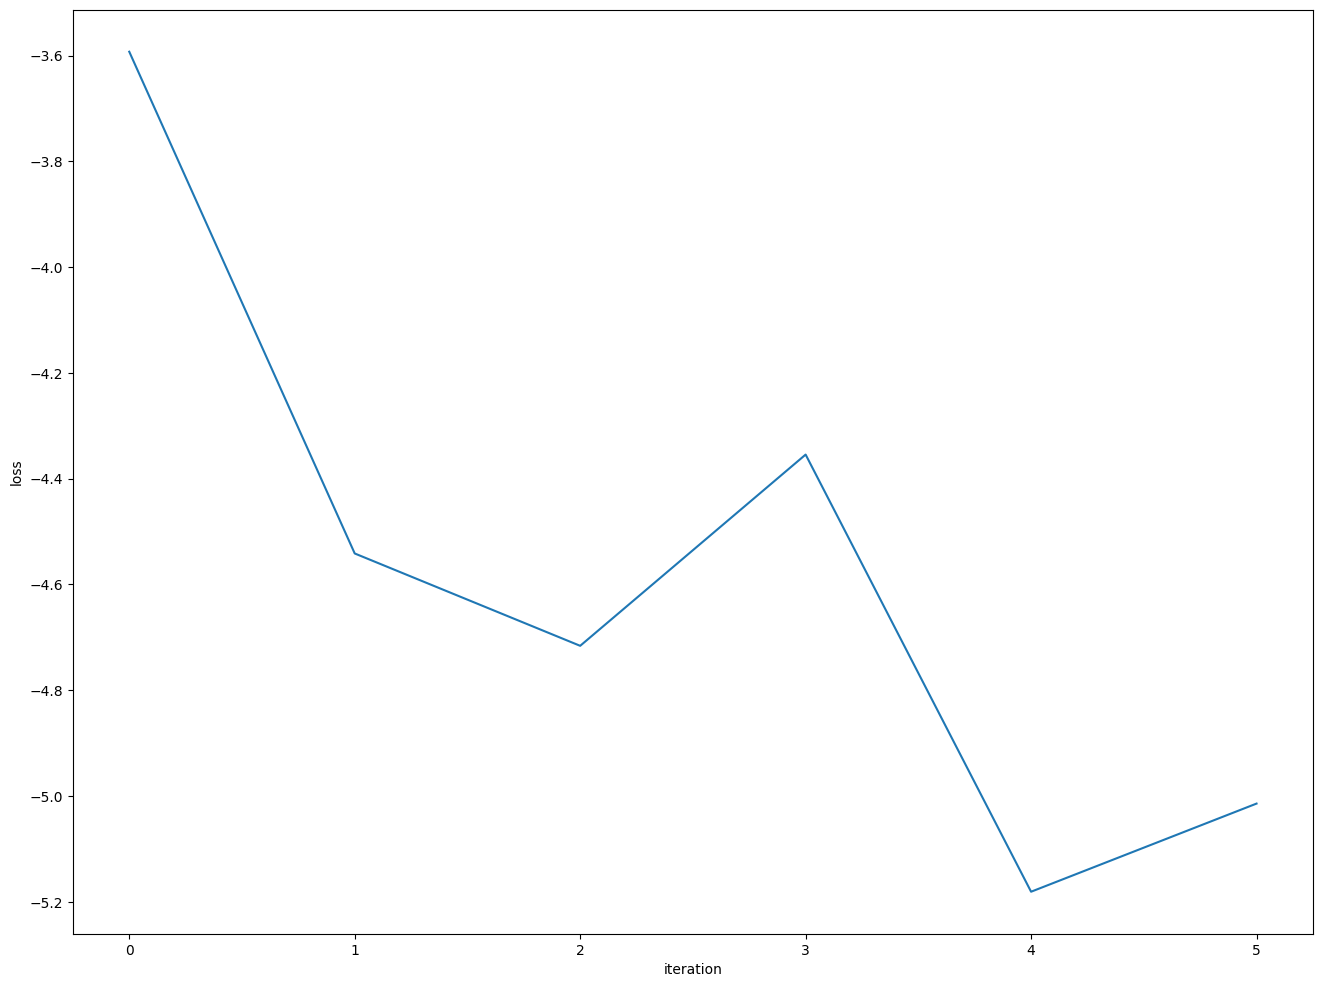

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")